<r>23.01.2023 r.<r>
<h1><center>Project - Web Scraping Wiki Dictionary</center></h1>
<h2><center>Analysis of unstructured data</center></h2>

<h3><center>Karol Bieńkowski, Jakub Łuczka, Kacper Paluch</center></h3>

In [1]:
# Importing necessery modules

# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulations
import numpy as np
import pandas as pd

# Count existance of the words
import collections

import requests
from bs4 import BeautifulSoup
import time
import pprint
import json

from tqdm import tqdm

<h3>Relationship graph of Wiktionary - statistics part of project</h3>

In this notebook we concentrate on exploring the headwords from Polish Wiktionary. From the downloaded definitions from Wikipedia dictionary as nested dict we create a DataFrame with all definitions and the basic wform of words which are used to describe others. We check the types of the words, the most popular words in the Polish dictionary, how many words from special fields of science are. We are also loooking for some regionalisms or dialect words or for the most popular used letters in Polish language to comparison them with official statistics from National Corpus of Polish Language.

In [2]:
import os
 
# Get the list of all files and directories
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
dir_list = os.listdir(path)
 
print("Files and directories in '", path, "' :", dir_list)

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: 'C:/Users/Kuba/Desktop/Analysis_Project/wiki/'

This is an example how the single headwords with their definitions looki like. As we wrote before, there are nested dicts with links to the words (not all exists).

In [125]:
file = dir_list[10]
f = open("C:/Users/Kuba/Desktop/Analysis_Project/wiki/{0}".format(file), 'r')
# returns JSON object as 
# a dictionary
data = json.load(f)


print(data)

print()
a = BeautifulSoup(data['definitions']['(1.1) ']['def.'][0], 'html.parser')
b = a.get_text()
print(b)
a = str(a)
print(a[28+7:46])
print(a.rfind('title="'))
print(a.rfind('">'))

print(len(data['definitions']))
# Looking for research publications which we are interested in
#research_papers = soup.find_all('ol')[2:]

{'definitions': {'(1.1) ': {'type': 'rzeczownik', 'def.': ['<style data-mw-deduplicate="TemplateStyles:r7574220">.mw-parser-output .short-container{font-style:italic;text-decoration:none}.mw-parser-output .short-no-style{font-style:normal}.mw-parser-output .short-container a:hover{color:#002bb8;text-decoration:underline}.mw-parser-output .short-container a,.mw-parser-output .short-container a:visited{color:black}.mw-parser-output .short-variant1 a,.mw-parser-output .short-variant1 a:visited{color:#002bb8}.mw-parser-output .short-variant2 a,.mw-parser-output .short-variant2 a:visited{color:red}.mw-parser-output .short-variant3 a,.mw-parser-output .short-variant3 a:visited{color:green}</style>', 'gw.', '(Śląsk Cieszyński)', 'rzem.', '<a href="/wiki/gw%C3%B3%C5%BAd%C5%BA" title="gwóźdź">gwóźdź</a>', '<a href="/wiki/kowalski" title="kowalski">kowalski</a>']}}, 'name': 'ófnol'}


eStyles:r75
-1
51
1


<h3>Headwords scraper from Wiktionary folder</h3>

This is a function which picks out the definitions of the words from the above form of words (which are from the downloading process). We creare a single row of Pandas Series to represent each headwords and each definitions (because some words can have more than one definition - some are connected to each other like 1.1 and 1.2 and some can be very different like 1.1 and 2.1).

In [3]:
def remove_suffix(input_string, suffix):
    if suffix and input_string.endswith(suffix):
        return input_string[:-len(suffix)]
    return input_string

In [4]:
def words_def_scraper(file):
    # Reading the .json file with the word
    f = open("C:/Users/Kuba/Desktop/Analysis_Project/wiki/{0}".format(file), 'r')
    f = f.read()
    data = json.loads(f)
    
    word =  BeautifulSoup(data['name'], 'html.parser')
    number_of_definitions = len(data['definitions'])
    
    # Creating a Data FRame with words definitions
    temp_df = pd.DataFrame()
    temp_df['Name'], temp_df['Sign'] = [], []
    temp_df['Type'] = []
    temp_df['Definition'], temp_df['Other_words'] = [], []
    temp_df['Indexes'], temp_df['No_words'] = [], []
    
    
    for i in range(1, number_of_definitions + 1):
        for k in range(1, number_of_definitions + 1):
            try:
                # Scrap the word type
                word_type = BeautifulSoup(data['definitions']['({0}.{1}) '.format(i, k)]['type'], 'html.parser')

                # Length of the definition
                word_def = data['definitions']['({0}.{1}) '.format(i, k)]['def.']
                word_def_length = len(word_def)

                # Definition of the word
                definition = ''
                sign = (i ,k)

                # Other words which describe this word
                other_words = []
                indexes = []

                for j in range(1, word_def_length):
                    part_word = BeautifulSoup(data['definitions']['({0}.{1}) '.format(i, k)]['def.'][j], 'html.parser')

                    index_word = part_word.get_text()
                    if index_word[-1] == '.':
                        indexes.append(index_word)

                    part_word_str = str(part_word)
                    start, end = part_word_str.rfind('title="'), part_word_str.rfind('">')
                    if (start != -1) and (end != -1):
                        href = part_word_str[start+7 : end]
                        href = remove_suffix(href, ' (strona nie istnieje)')
                        other_words.append(href)

                    definition += '{0} '.format(part_word.get_text())
                
                if len(indexes) == 0:
                    indexes = None
                
                new_row = pd.Series({'Name': word.get_text(), 'Sign' : sign, 'Type': word_type.get_text(), 'Definition': definition, 
                           'Other_words' : other_words, 'Indexes' : indexes, 'No_words' : word_def_length - 1})
                temp_df = pd.concat([temp_df, new_row.to_frame().T], ignore_index=True)
                
            except:
                pass
            
    return temp_df


In [5]:
# Get the list of all files and directories
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
dir_list = os.listdir(path)
file = dir_list[309]

words_def_scraper(file)

Name    Sign       Type          Definition        Other_words Indexes  \
0  łacznąć  (1, 1)  czasownik  łaknąć ,  pożądać   [łaknąć, pożądać]    None   

  No_words  
0        3

<h3>Polish Wiktionary creator</h3>

In this part we create our Wiktionary dict with all headwords which we scraped before. The dictionary is a DataFrame with rows which are represented the headwords with definitions, types, other words (and their number) used to describe them, indexes (like a word is from Physics or Geography etc.).

In [6]:
def wiki_dictionary_creator(path, start_iter, end_iter, csv_name):
    # Creating wiki dictionary as a DataFrame
    dict_df = pd.DataFrame()
    dict_df['Name'], dict_df['Sign'] = [], []
    dict_df['Type'] = []
    dict_df['Definition'], dict_df['Other_words'] = [], []
    dict_df['Indexes'], dict_df['No_words'] = [], []
    
    dir_list = os.listdir(path)
    
    for i in tqdm(range(start_iter, end_iter), desc = 'Progress'):
        if end_iter <= len(dir_list):
            try:
                file = dir_list[i]
                single_df = words_def_scraper(file)
                dict_df = pd.concat([dict_df, single_df], ignore_index = True)
            except:
                print(i)
                
    dict_df.to_csv('wiki_dict_{0}.csv'.format(csv_name))
    return dict_df


Splitting all words into 10 parts of scrapping all files from wiki folder, because it makes the process of creating dictionary more faster (Pandas concat is very slow if the DataFrame becomes bigger and bigger).

In [351]:
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 0, 10000
csv_name = '1'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   1%|          | 87/10000 [00:00<00:48, 205.79it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   2%|▏         | 220/10000 [00:01<00:46, 211.88it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   3%|▎         | 310/10000 [00:01<00:46, 208.27it/s]C:\Us

Name    Sign                   Type  \
0                  Å  (1, 1)                   None   
1      Île-de-France  (1, 1)             rzeczownik   
2      Île-de-France  (1, 2)             rzeczownik   
3                  Ó  (1, 1)             rzeczownik   
4                  à  (1, 1)               przyimek   
...              ...     ...                    ...   
14178     Bermudczyk  (1, 1)             rzeczownik   
14179       Bermudka  (1, 1)             rzeczownik   
14180        Bermudy  (1, 1)             rzeczownik   
14181        Bermudy  (1, 2)             rzeczownik   
14182      bermudzki  (1, 1)  przymiotnik relacyjny   

                                              Definition  \
0       metrol. fiz. symbol jednostki długości angstrem    
1      geogr. hist. kraina historyczna zawierająca Pa...   
2      adm. region administracyjny Francji ,  zawiera...   
3      jęz. majuskuła dwudziestej pierwszej litery al...   
4             – używane w handlu przy określaniu ilości    
...                                                  ...   
14178                                          Bermudów    
14179                                          Bermudów    
14180  geogr. polit. terytorium zależne Wielkiej Bryt...   
14181  archipelag na Oceanie Atlantyckim ,  w Ameryce...   
14182                                          Bermudów    

                                             Other_words           Indexes  \
0                 [symbol, jednostka, długość, angstrem]   [metrol., fiz.]   
1      [kraina, historyczny, zawierać, Paryż, z, przy...   [geogr., hist.]   
2      [region, administracyjny, Francja, zawierać, w...            [adm.]   
3      [majuskuła, dwudziesty, pierwszy, litera, alfa...            [jęz.]   
4        [–, używać, w, handel, przy, określanie, ilość]              None   
...                                                  ...               ...   
14178                                          [Bermudy]              None   
14179                                          [Bermudy]              None   
14180          [terytorium zależne, Wielka Brytania, na]  [geogr., polit.]   
14181  [archipelag, na, Ocean Atlantycki, w, Ameryka ...              None   
14182                                          [Bermudy]              None   

      No_words  
0            6  
1           14  
2           12  
3            8  
4            7  
...        ...  
14178        1  
14179        1  
14180        8  
14181        6  
14182        1  

[14183 rows x 7 columns]

In [4]:
csv_name = '1'
wiki_dictionary = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_dictionary.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_dictionary.head()

Name    Sign        Type  \
0              Å  (1, 1)        None   
1  Île-de-France  (1, 1)  rzeczownik   
2  Île-de-France  (1, 2)  rzeczownik   
3              Ó  (1, 1)  rzeczownik   
4              à  (1, 1)    przyimek   

                                          Definition  \
0   metrol. fiz. symbol jednostki długości angstrem    
1  geogr. hist. kraina historyczna zawierająca Pa...   
2  adm. region administracyjny Francji ,  zawiera...   
3  jęz. majuskuła dwudziestej pierwszej litery al...   
4         – używane w handlu przy określaniu ilości    

                                         Other_words              Indexes  \
0     ['symbol', 'jednostka', 'długość', 'angstrem']  ['metrol.', 'fiz.']   
1  ['kraina', 'historyczny', 'zawierać', 'Paryż',...  ['geogr.', 'hist.']   
2  ['region', 'administracyjny', 'Francja', 'zawi...             ['adm.']   
3  ['majuskuła', 'dwudziesty', 'pierwszy', 'liter...             ['jęz.']   
4  ['–', 'używać', 'w', 'handel', 'przy', 'określ...                  NaN   

   No_words  
0         6  
1        14  
2        12  
3         8  
4         7

In [339]:
# Part 2
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 10000, 20000
csv_name = '12'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   1%|▏         | 143/10000 [00:00<00:38, 258.08it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   6%|▌         | 601/10000 [00:02<00:35, 266.25it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  11%|█▏        | 1141/10000 [00:04<00:32, 271.87it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  13%|█▎        | 1251/10000 [00:04<00:33, 25

18165


Progress:  84%|████████▍ | 8424/10000 [00:34<00:06, 261.51it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  85%|████████▌ | 8504/10000 [00:35<00:05, 252.76it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  86%|████████▌ | 8579/10000 [00:35<00:06, 236.78it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  89%|████████▊ | 8873/10000 [00:36<00:04, 

Name    Sign                 Type  \
0                    Bernadeta  (1, 1)           rzeczownik   
1                   Bernadetka  (1, 1)           rzeczownik   
2        bernardyn krótkowłosy  (1, 1)  fraza rzeczownikowa   
3     berneński pies pasterski  (1, 1)  fraza rzeczownikowa   
4                        Berno  (1, 1)           rzeczownik   
...                        ...     ...                  ...   
5050                  dominium  (1, 3)           rzeczownik   
5051                 domofonik  (1, 1)           rzeczownik   
5052                domokrążca  (1, 2)           rzeczownik   
5053               domorosłość  (1, 1)           rzeczownik   
5054                 domorosły  (1, 2)          przymiotnik   

                                             Definition  \
0     ofic. urz. imię żeńskie ;  zob. też Bernadeta ...   
1     zdrobn. poufała forma żeńskiego imienia Bernad...   
2     kynol. odmiana rasy psa zaliczana do grupy mol...   
3     kynol. rasa psa należąca do grupy szwajcarskic...   
4     geogr. stolica Szwajcarii ;  zob. też Berno w ...   
...                                                 ...   
5050  adm. forma ustrojowa imperium brytyjskiego ,  ...   
5051                                zdrobn. od domofon    
5052                                    zob. akwizytor    
5053  odprzym. cecha tego ,  co jest domorosłe ;  ce...   
5054                        iron. swojski ,  miejscowy    

                                            Other_words        Indexes  \
0                                                    []  [ofic., urz.]   
1             [poufały, forma, żeński, imię, Bernadeta]      [zdrobn.]   
2     [odmiana, rasa, pies, zaliczać, do, grupa, mol...       [kynol.]   
3     [rasa, pies, należeć, do, grupa, szwajcarski, ...       [kynol.]   
4                                 [stolica, Szwajcaria]       [geogr.]   
...                                                 ...            ...   
5050  [forma, ustrojowy, imperium, brytyjski, pośred...         [adm.]   
5051                                          [domofon]      [zdrobn.]   
5052                                                 []         [zob.]   
5053  [cecha, to, co, być, domorosły, cecha, ci, któ...     [odprzym.]   
5054                               [swojski, miejscowy]        [iron.]   

     No_words  
0           5  
1           6  
2          11  
3          11  
4           5  
...       ...  
5050       15  
5051        3  
5052        2  
5053       14  
5054        4  

[5055 rows x 7 columns]

In [5]:
csv_name = '2'
wiki_part2 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part2.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part2.head()

Name    Sign                   Type  \
0       bermyca  (1, 1)             rzeczownik   
1     Bernadeta  (1, 1)             rzeczownik   
2    Bernadetka  (1, 1)             rzeczownik   
3       Bernard  (1, 1)             rzeczownik   
4  bernardyński  (1, 1)  przymiotnik relacyjny   

                                          Definition  \
0   futrzana czapka ;  zob. też bermyca w Wikipedii    
1  ofic. urz. imię żeńskie ;  zob. też Bernadeta ...   
2  zdrobn. poufała forma żeńskiego imienia Bernad...   
3            ;  zob. też Bernard (imię) w Wikipedii    
4                             z zakonem bernardynów    

                                         Other_words            Indexes  \
0                             ['futrzany', 'czapka']                NaN   
1                                                 []  ['ofic.', 'urz.']   
2  ['poufały', 'forma', 'żeński', 'imię', 'Bernad...        ['zdrobn.']   
3                                                 []                NaN   
4                        ['z', 'zakon', 'bernardyn']                NaN   

   No_words  
0         4  
1         5  
2         6  
3         2  
4         3

In [225]:
# Part 3
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 20000, 30000
csv_name = '3'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   1%|          | 122/10000 [00:01<01:34, 104.50it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   3%|▎         | 298/10000 [00:02<01:27, 110.44it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   5%|▌         | 510/10000 [00:04<01:32, 102.08it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   6%|▌         | 622/10000 [00:05<01:26, 108.

Name    Sign                   Type  \
0           domykanie  (1, 1)             rzeczownik   
1              domysł  (1, 1)             rzeczownik   
2      dom akademicki  (1, 1)    fraza rzeczownikowa   
3      dom bez klamek  (1, 1)    fraza rzeczownikowa   
4         dom dziecka  (1, 1)    fraza rzeczownikowa   
...               ...     ...                    ...   
14289         Hippona  (1, 1)             rzeczownik   
14290  hipsometryczny  (1, 1)  przymiotnik relacyjny   
14291         hipster  (1, 1)             rzeczownik   
14292         hipster  (1, 2)             rzeczownik   
14293       hipsterka  (1, 1)             rzeczownik   

                                              Definition  \
0                             rzecz. odczas. od domykać    
1                                        ,  domniemanie    
2      budynek ,  w którym mieszkają studenci ;  zob....   
3                    pot. eufem. szpital psychiatryczny    
4      opiekuńczo - wychowawcza typu socjalizacyjnego...   
...                                                  ...   
14289  geogr. hist. starożytne miasto w północno-wsch...   
14290            z hipsometrią ,  dotyczący hipsometrii    
14291  subkultury miejskiej w Stanach Zjednoczonych ,...   
14292  ,  która akcentuje swoją oryginalność i niezal...   
14293                                        :  hipster    

                                             Other_words           Indexes  \
0                                                     []  [rzecz. odczas.]   
1                                          [domniemanie]              None   
2                 [budynek, w, który, mieszkać, student]              None   
3                               [szpital psychiatryczny]    [pot., eufem.]   
4      [opiekuńczy, wychowawczy, typ, socjalizacyjny,...              None   
...                                                  ...               ...   
14289  [starożytny, miasto, w, północno-wschodni, Alg...   [geogr., hist.]   
14290            [z, hipsometria, dotyczyć, hipsometria]              None   
14291  [subkultura, miejski, w, Stany Zjednoczone, zw...              None   
14292  [który, akcentować, swój, oryginalność, i, nie...              None   
14293                                          [hipster]              None   

      No_words  
0            3  
1            2  
2            8  
3            3  
4           24  
...        ...  
14289       14  
14290        5  
14291       15  
14292       26  
14293        2  

[14294 rows x 7 columns]

In [6]:
csv_name = '3'
wiki_part3 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part3.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part3.head()

Name    Sign                 Type  \
0       domykanie  (1, 1)           rzeczownik   
1          domysł  (1, 1)           rzeczownik   
2  dom akademicki  (1, 1)  fraza rzeczownikowa   
3  dom bez klamek  (1, 1)  fraza rzeczownikowa   
4     dom dziecka  (1, 1)  fraza rzeczownikowa   

                                          Definition  \
0                         rzecz. odczas. od domykać    
1                                    ,  domniemanie    
2  budynek ,  w którym mieszkają studenci ;  zob....   
3                pot. eufem. szpital psychiatryczny    
4  opiekuńczo - wychowawcza typu socjalizacyjnego...   

                                         Other_words             Indexes  \
0                                                 []  ['rzecz. odczas.']   
1                                    ['domniemanie']                 NaN   
2   ['budynek', 'w', 'który', 'mieszkać', 'student']                 NaN   
3                         ['szpital psychiatryczny']  ['pot.', 'eufem.']   
4  ['opiekuńczy', 'wychowawczy', 'typ', 'socjaliz...                 NaN   

   No_words  
0         3  
1         2  
2         8  
3         3  
4        24

In [227]:
# Part 4
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 30000, 40000
csv_name = '4'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   0%|          | 48/10000 [00:00<01:28, 112.25it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   9%|▉         | 937/10000 [00:08<01:20, 112.50it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  10%|▉         | 986/10000 [00:09<01:25, 105.43it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  11%|█         | 1072/10000 [00:09<01:14, 119.

32787


Progress:  30%|███       | 3021/10000 [00:28<01:10, 99.31it/s] C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  32%|███▏      | 3230/10000 [00:30<01:06, 101.07it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  32%|███▏      | 3241/10000 [00:30<01:07, 100.29it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-pac

Name    Sign                   Type  \
0         hipsterski  (1, 1)  przymiotnik relacyjny   
1      hip hip hurra  (1, 1)    fraza wykrzyknikowa   
2           hiragana  (1, 1)             rzeczownik   
3           Hireczek  (1, 1)             rzeczownik   
4              Hirek  (1, 1)             rzeczownik   
...              ...     ...                    ...   
14429         krwawy  (1, 5)            przymiotnik   
14430         krwawy  (1, 6)            przymiotnik   
14431      krwiściąg  (1, 1)             rzeczownik   
14432      krwiaczek  (1, 1)             rzeczownik   
14433         krwiak  (1, 1)             rzeczownik   

                                              Definition  \
0      z hipsterem lub hipsterką ,  odnoszący się do ...   
1                      wyrażający entuzjazm lub euforię    
2      jeden z dwóch japońskich systemów pisma sylabi...   
3       zdrobn. poufała forma męskiego imienia Hieronim    
4                                      zdrobn. Hieronim    
...                                                  ...   
14429                         przypominający kolor krwi    
14430                             o pracy bardzo ciężki    
14431  krzewinka lub bylina z rodziny różowatych wyst...   
14432                                 zdrobn. od krwiak    
14433  med. patologiczne nagromadzenie krwi w organiz...   

                                             Other_words    Indexes No_words  
0      [z, hipster, lub, hipsterka, odnosić się, do, ...       None       10  
1                     [wyrażać, entuzjazm, lub, euforia]       None        4  
2      [jeden, z, dwa, japoński, system, pismo, sylab...       None       10  
3                [poufały, forma, męski, imię, Hieronim]  [zdrobn.]        6  
4                                             [Hieronim]  [zdrobn.]        2  
...                                                  ...        ...      ...  
14429                         [przypominać, kolor, krew]       None        3  
14430                                   [bardzo, ciężki]       None        3  
14431  [krzewinka, lub, bylina, z, rodzina, różowate,...       None       14  
14432                                           [krwiak]  [zdrobn.]        3  
14433   [patologiczny, nagromadzenie, krew, w, organizm]     [med.]        8  

[14434 rows x 7 columns]

In [7]:
csv_name = '4'
wiki_part4 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part4.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part4.head()

Name    Sign                   Type  \
0     hipsterski  (1, 1)  przymiotnik relacyjny   
1  hip hip hurra  (1, 1)    fraza wykrzyknikowa   
2       hiragana  (1, 1)             rzeczownik   
3       Hireczek  (1, 1)             rzeczownik   
4          Hirek  (1, 1)             rzeczownik   

                                          Definition  \
0  z hipsterem lub hipsterką ,  odnoszący się do ...   
1                  wyrażający entuzjazm lub euforię    
2  jeden z dwóch japońskich systemów pisma sylabi...   
3   zdrobn. poufała forma męskiego imienia Hieronim    
4                                  zdrobn. Hieronim    

                                         Other_words      Indexes  No_words  
0  ['z', 'hipster', 'lub', 'hipsterka', 'odnosić ...          NaN        10  
1         ['wyrażać', 'entuzjazm', 'lub', 'euforia']          NaN         4  
2  ['jeden', 'z', 'dwa', 'japoński', 'system', 'p...          NaN        10  
3  ['poufały', 'forma', 'męski', 'imię', 'Hieronim']  ['zdrobn.']         6  
4                                       ['Hieronim']  ['zdrobn.']         2

In [229]:
# Part 5
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 40000, 50000
csv_name = '5'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   4%|▎         | 365/10000 [00:03<01:26, 111.35it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   5%|▍         | 455/10000 [00:04<01:30, 104.96it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   7%|▋         | 662/10000 [00:06<01:30, 103.35it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packag

41206


Progress:  13%|█▎        | 1265/10000 [00:12<01:21, 107.11it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  19%|█▊        | 1852/10000 [00:18<01:26, 94.31it/s] C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  19%|█▉        | 1885/10000 [00:18<01:20, 101.17it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-pac

46288


Progress:  66%|██████▌   | 6613/10000 [01:06<00:35, 94.78it/s] C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  70%|███████   | 7012/10000 [01:11<00:33, 90.00it/s] C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  72%|███████▏  | 7245/10000 [01:13<00:28, 95.77it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  73%|███████▎  | 7275/10000 [01:13<00:30, 8

49380


Progress:  96%|█████████▌| 9568/10000 [01:39<00:04, 91.69it/s]

49559


Progress:  96%|█████████▌| 9598/10000 [01:39<00:04, 91.58it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  96%|█████████▌| 9608/10000 [01:40<00:04, 91.96it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  97%|█████████▋| 9668/10000 [01:40<00:03, 92.62it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  97%|█████████▋| 9678/10000 [01:40<00:03, 91.

Name    Sign                   Type  \
0               krwinka  (1, 1)             rzeczownik   
1         krwinka biała  (1, 1)    fraza rzeczownikowa   
2      krwinka czerwona  (1, 1)    fraza rzeczownikowa   
3             krwinkowy  (1, 1)  przymiotnik relacyjny   
4         krwiożerczość  (1, 1)             rzeczownik   
...                 ...     ...                    ...   
14270        nesebyrski  (1, 1)  przymiotnik relacyjny   
14271           neseser  (1, 1)             rzeczownik   
14272            Nestor  (1, 1)             rzeczownik   
14273      nestoriański  (1, 1)            przymiotnik   
14274       nestorianin  (1, 1)             rzeczownik   

                                              Definition  \
0                                          komórka krwi    
1      biol. med. krwinka odpowiadająca za ochronę us...   
2      biol. med. element komórkowy krwi ,  nadający ...   
3                        z krwinką ,  dotyczący krwinki    
4      tego ,  kto krwiożerczy ;  cecha tego ,  co kr...   
...                                                  ...   
14270                 z Nesebyrem ,  dotyczący Nesebyru    
14271  walizka lub torba na podręczne przybory ,  rze...   
14272             ;  zob. też Nestor (imię) w Wikipedii    
14273                      rel. dotyczący nestorianizmu    
14274  rel. wyznawca ,  zwolennik doktryny nestoriani...   

                                             Other_words        Indexes  \
0                                        [komórka, krew]           None   
1             [krwinka, odpowiadać, za, ochrona, ustrój]  [biol., med.]   
2      [element, komórkowy, krew, nadawać, ona, barwa...  [biol., med.]   
3                          [z, kwinka, dotyczyć, kwinka]           None   
4      [to, kto, krwiożerczy, cecha, to, co, krwiożer...           None   
...                                                  ...            ...   
14270                    [z, Nesebyr, dotyczyć, Nesebyr]           None   
14271  [walizka, lub, torba, na, podręczny, przybór, ...           None   
14272                                                 []           None   
14273                           [dotyczyć, nestorianizm]         [rel.]   
14274      [wyznawca, zwolennik, doktryna, nestorianizm]         [rel.]   

      No_words  
0            2  
1            7  
2           20  
3            5  
4           10  
...        ...  
14270        5  
14271       13  
14272        2  
14273        3  
14274        6  

[14275 rows x 7 columns]

In [8]:
csv_name = '5'
wiki_part5 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part5.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part5.head()

Name    Sign                   Type  \
0           krwinka  (1, 1)             rzeczownik   
1     krwinka biała  (1, 1)    fraza rzeczownikowa   
2  krwinka czerwona  (1, 1)    fraza rzeczownikowa   
3         krwinkowy  (1, 1)  przymiotnik relacyjny   
4     krwiożerczość  (1, 1)             rzeczownik   

                                          Definition  \
0                                      komórka krwi    
1  biol. med. krwinka odpowiadająca za ochronę us...   
2  biol. med. element komórkowy krwi ,  nadający ...   
3                    z krwinką ,  dotyczący krwinki    
4  tego ,  kto krwiożerczy ;  cecha tego ,  co kr...   

                                         Other_words            Indexes  \
0                                ['komórka', 'krew']                NaN   
1  ['krwinka', 'odpowiadać', 'za', 'ochrona', 'us...  ['biol.', 'med.']   
2  ['element', 'komórkowy', 'krew', 'nadawać', 'o...  ['biol.', 'med.']   
3              ['z', 'kwinka', 'dotyczyć', 'kwinka']                NaN   
4  ['to', 'kto', 'krwiożerczy', 'cecha', 'to', 'c...                NaN   

   No_words  
0         2  
1         7  
2        20  
3         5  
4        10

In [231]:
# Part 6
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 50000, 60000
csv_name = '6'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   1%|▏         | 144/10000 [00:01<01:35, 103.19it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   3%|▎         | 316/10000 [00:02<01:21, 119.31it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  18%|█▊        | 1796/10000 [00:15<01:05, 124.84it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  25%|██▌       | 2519/10000 [00:21<01:01, 12

54826


Progress:  50%|█████     | 5000/10000 [00:43<00:48, 102.94it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  50%|█████     | 5044/10000 [00:43<00:50, 99.05it/s] C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  52%|█████▏    | 5210/10000 [00:45<00:46, 102.59it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  53%|█████▎    | 5276/10000 [00:45<00:47, 

57746


Progress:  81%|████████  | 8084/10000 [01:15<00:20, 95.21it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  82%|████████▏ | 8221/10000 [01:17<00:20, 86.34it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  84%|████████▍ | 8407/10000 [01:19<00:18, 85.33it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  85%|████████▍ | 8462/10000 [01:20<00:19, 79.

Name    Sign                   Type  \
0               nestorianizm  (1, 1)             rzeczownik   
1                nestorianka  (1, 1)             rzeczownik   
2                        net  (1, 1)             rzeczownik   
3                 netballowy  (1, 1)  przymiotnik relacyjny   
4                    netbook  (1, 1)             rzeczownik   
...                      ...     ...                    ...   
13187   Półwysep Salentyński  (1, 1)    fraza rzeczownikowa   
13188     Półwysep Sambijski  (1, 1)    fraza rzeczownikowa   
13189  Półwysep Skandynawski  (1, 1)    fraza rzeczownikowa   
13190    Półwysep Somalijski  (1, 1)    fraza rzeczownikowa   
13191      Półwysep Tamański  (1, 1)    fraza rzeczownikowa   

                                              Definition  \
0      rel. chrześcijańska doktryna chrystologiczna ,...   
1      rel. wyznawczyni ,  zwolenniczka doktryny nest...   
2                                  pot. młodz. Internet    
3                     z netballem ,  dotyczący netballu    
4      ,  komputer przenośny mniejszy od notebooka , ...   
...                                                  ...   
13187  geogr. południowo-wschodnie odgałęzienie Półwy...   
13188  geogr. półwysep na terenie Rosji rozdzielający...   
13189  geogr. półwysep w Europie Północnej ;  zob. te...   
13190  geogr. półwysep we wschodniej Afryce ,  między...   
13191  geogr. półwysep na południu europejskiej częśc...   

                                             Other_words         Indexes  \
0      [chrześcijański, doktryna, chrystologiczny, kt...          [rel.]   
1      [wyznawczyni, zwolenniczka, doktryna, nestoria...          [rel.]   
2                                             [Internet]  [pot., młodz.]   
3                        [z, netball, dotyczyć, netball]            None   
4      [komputer, przenośny, mały, od, notebook, prze...            None   
...                                                  ...             ...   
13187  [południowo-wschodni, odgałęzienie, Półwysep A...        [geogr.]   
13188  [półwysep, na, teren, Rosja, rozdzielać, Zalew...        [geogr.]   
13189                     [półwysep, w, Europa Północna]        [geogr.]   
13190  [półwysep, we, wschodni, Afryka, między, Zatok...        [geogr.]   
13191  [półwysep, na, południe, europejski, część, Fe...        [geogr.]   

      No_words  
0           24  
1            6  
2            3  
3            5  
4           22  
...        ...  
13187       11  
13188       11  
13189        6  
13190       10  
13191       21  

[13192 rows x 7 columns]

In [9]:
csv_name = '6'
wiki_part6 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part6.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part6.head()

Name    Sign                   Type  \
0  nestorianizm  (1, 1)             rzeczownik   
1   nestorianka  (1, 1)             rzeczownik   
2           net  (1, 1)             rzeczownik   
3    netballowy  (1, 1)  przymiotnik relacyjny   
4       netbook  (1, 1)             rzeczownik   

                                          Definition  \
0  rel. chrześcijańska doktryna chrystologiczna ,...   
1  rel. wyznawczyni ,  zwolenniczka doktryny nest...   
2                              pot. młodz. Internet    
3                 z netballem ,  dotyczący netballu    
4  ,  komputer przenośny mniejszy od notebooka , ...   

                                         Other_words             Indexes  \
0  ['chrześcijański', 'doktryna', 'chrystologiczn...            ['rel.']   
1  ['wyznawczyni', 'zwolenniczka', 'doktryna', 'n...            ['rel.']   
2                                       ['Internet']  ['pot.', 'młodz.']   
3            ['z', 'netball', 'dotyczyć', 'netball']                 NaN   
4  ['komputer', 'przenośny', 'mały', 'od', 'noteb...                 NaN   

   No_words  
0        24  
1         6  
2         3  
3         5  
4        22

In [233]:
# Part 7
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 60000, 70000
csv_name = '7'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   6%|▌         | 610/10000 [00:06<01:32, 101.60it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   6%|▋         | 632/10000 [00:06<01:33, 100.03it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   6%|▋         | 643/10000 [00:06<01:36, 97.07it/s] C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   7%|▋         | 676/10000 [00:06<01:30, 103.

63088


Progress:  32%|███▏      | 3228/10000 [00:32<01:15, 90.03it/s] C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  37%|███▋      | 3739/10000 [00:37<01:02, 100.93it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  39%|███▉      | 3888/10000 [00:39<01:02, 98.00it/s] C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  42%|████▏     | 4192/10000 [00:42<01:00, 

67174


Progress:  73%|███████▎  | 7339/10000 [01:16<00:30, 88.25it/s]

67325


C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  75%|███████▍  | 7471/10000 [01:18<00:28, 88.84it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  75%|███████▌  | 7525/10000 [01:19<00:30, 79.90it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The inp

Name    Sign                   Type  \
0                 Półwysep Walijski  (1, 1)    fraza rzeczownikowa   
1      Półwysep Zielonego Przylądka  (1, 1)    fraza rzeczownikowa   
2                        półwyspowy  (1, 1)  przymiotnik relacyjny   
3                       półwytrawny  (1, 1)            przymiotnik   
4                     półzimotrwały  (1, 1)            przymiotnik   
...                             ...     ...                    ...   
15094               przyjacielskość  (1, 1)             rzeczownik   
15095                 przyjacielsko  (1, 1)             przysłówek   
15096               przyjaciel domu  (1, 1)    fraza rzeczownikowa   
15097                      przyjazd  (1, 1)             rzeczownik   
15098                      przyjazd  (1, 2)             rzeczownik   

                                              Definition  \
0      geogr. półwysep w południowo-zachodniej części...   
1      geogr. półwysep w zachodnim Senegalu nad Ocean...   
2                   do półwyspu ,  związany z półwyspem    
3      o napojach alkoholowych: mający smak pośredni ...   
4                                prawie przez całą zimę    
...                                                  ...   
15094                    tego ,  co jest przyjacielskie    
15095                sposób przyjacielski ,  przyjaźnie    
15096  często bywająca w danym domu ,  zaprzyjaźniona...   
15097                               do jakiegoś miejsca    
15098                                           pojazdu    

                                             Other_words   Indexes No_words  
0      [półwysep, w, południowo-zachodni, część, wysp...  [geogr.]       12  
1      [półwysep, w, zachodni, Senegal, nad, Ocean At...  [geogr.]        7  
2                   [do, półwysep, związać, z, półwysep]      None        6  
3      [mieć, smak, pośredni, między, wytrawny, a, pó...      None        8  
4                            [prawie, przez, cały, zima]      None        4  
...                                                  ...       ...      ...  
15094                      [ten, co, być, przyjacielski]      None        5  
15095                [sposób, przyjacielski, przyjaźnie]      None        4  
15096  [często, bywać, w, dany, dom, zaprzyjaźniona, ...      None       15  
15097                               [do, jakiś, miejsce]      None        3  
15098                                           [pojazd]      None        1  

[15099 rows x 7 columns]

In [10]:
csv_name = '7'
wiki_part7 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part7.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part7.head()

Name    Sign                   Type  \
0             Półwysep Walijski  (1, 1)    fraza rzeczownikowa   
1  Półwysep Zielonego Przylądka  (1, 1)    fraza rzeczownikowa   
2                    półwyspowy  (1, 1)  przymiotnik relacyjny   
3                   półwytrawny  (1, 1)            przymiotnik   
4                 półzimotrwały  (1, 1)            przymiotnik   

                                          Definition  \
0  geogr. półwysep w południowo-zachodniej części...   
1  geogr. półwysep w zachodnim Senegalu nad Ocean...   
2               do półwyspu ,  związany z półwyspem    
3  o napojach alkoholowych: mający smak pośredni ...   
4                            prawie przez całą zimę    

                                         Other_words     Indexes  No_words  
0  ['półwysep', 'w', 'południowo-zachodni', 'częś...  ['geogr.']        12  
1  ['półwysep', 'w', 'zachodni', 'Senegal', 'nad'...  ['geogr.']         7  
2     ['do', 'półwysep', 'związać', 'z', 'półwysep']         NaN         6  
3  ['mieć', 'smak', 'pośredni', 'między', 'wytraw...         NaN         8  
4                ['prawie', 'przez', 'cały', 'zima']         NaN         4

In [235]:
# Part 8
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 70000, 80000
csv_name = '8'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   0%|          | 10/10000 [00:00<01:43, 96.81it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   1%|▏         | 145/10000 [00:01<01:48, 90.76it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init_

78762


Progress:  90%|████████▉ | 8975/10000 [01:37<00:12, 80.35it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  92%|█████████▏| 9167/10000 [01:39<00:10, 79.14it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  92%|█████████▏| 9211/10000 [01:39<00:09, 80.56it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packag

Name    Sign  \
0                    przyjazność  (1, 1)   
1                      przyjazny  (1, 1)   
2                      przyjazny  (1, 2)   
3      przyjdzie walec i wyrówna  (1, 1)   
4                    przyjeżdżać  (1, 1)   
...                          ...     ...   
14936                  stygmatyk  (1, 1)   
14937              stygmatyzacja  (1, 1)   
14938              stygmatyzacja  (1, 2)   
14939            stygmatyzowanie  (1, 1)   
14940                   stykówka  (1, 1)   

                                                    Type  \
0                                             rzeczownik   
1                                 przymiotnik jakościowy   
2                                 przymiotnik jakościowy   
3                                 związek frazeologiczny   
4      czasownik nieprzechodni niedokonany (dk. przyj...   
...                                                  ...   
14936                                         rzeczownik   
14937                                         rzeczownik   
14938                                         rzeczownik   
14939                                         rzeczownik   
14940                                         rzeczownik   

                                              Definition  \
0      odprzym. cecha tego ,  co jest przyjazne ;  ce...   
1      ,  który żywi dla kogoś  /  czegoś uczucie prz...   
2      taki ,  który sprzyja komuś  /  czemuś i nie p...   
3      się ktoś ,  kto naprawi daną sytuację ,  rozwi...   
4                 przybywać za pomocą pojazdu na kołach    
...                                                  ...   
14936  rel. osoba ze śladami ran Chrystusowych na ciele    
14937                  potępianie danej osoby lub grupy    
14938  nadawania ,  często negatywnych ,  określeń os...   
14939                   rzecz. odczas. od stygmatyzować    
14940  odbitka fotograficzna służąca do uzyskania wgl...   

                                             Other_words           Indexes  \
0      [cecha, to, co, być, przyjazny, cecha, ci, któ...        [odprzym.]   
1      [który, żywić, dla, ktoś, coś, uczucie, przyja...              None   
2      [taki, który, sprzyjać, ktoś, coś, i, nie, prz...              None   
3      [się, ktoś, kto, naprawić, dany, sytuacja, roz...              None   
4               [przybywać, za pomocą, pojazd, na, koło]              None   
...                                                  ...               ...   
14936    [osoba, ze, ślad, rana, Chrystusowy, na, ciało]            [rel.]   
14937              [potępianie, dany, osoba, lub, grupa]              None   
14938  [nadawanie, często, negatywny, określenie, oso...              None   
14939                                                 []  [rzecz. odczas.]   
14940  [odbitka, fotograficzny, służyć, do, uzyskanie...              None   

      No_words  
0           14  
1           14  
2           11  
3           10  
4            5  
...        ...  
14936        8  
14937        5  
14938       12  
14939        3  
14940       19  

[14941 rows x 7 columns]

In [11]:
csv_name = '8'
wiki_part8 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part8.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part8.head()

Name    Sign  \
0                przyjazność  (1, 1)   
1                  przyjazny  (1, 1)   
2                  przyjazny  (1, 2)   
3  przyjdzie walec i wyrówna  (1, 1)   
4                przyjeżdżać  (1, 1)   

                                                Type  \
0                                         rzeczownik   
1                             przymiotnik jakościowy   
2                             przymiotnik jakościowy   
3                             związek frazeologiczny   
4  czasownik nieprzechodni niedokonany (dk. przyj...   

                                          Definition  \
0  odprzym. cecha tego ,  co jest przyjazne ;  ce...   
1  ,  który żywi dla kogoś  /  czegoś uczucie prz...   
2  taki ,  który sprzyja komuś  /  czemuś i nie p...   
3  się ktoś ,  kto naprawi daną sytuację ,  rozwi...   
4             przybywać za pomocą pojazdu na kołach    

                                         Other_words       Indexes  No_words  
0  ['cecha', 'to', 'co', 'być', 'przyjazny', 'cec...  ['odprzym.']        14  
1  ['który', 'żywić', 'dla', 'ktoś', 'coś', 'uczu...           NaN        14  
2  ['taki', 'który', 'sprzyjać', 'ktoś', 'coś', '...           NaN        11  
3  ['się', 'ktoś', 'kto', 'naprawić', 'dany', 'sy...           NaN        10  
4  ['przybywać', 'za pomocą', 'pojazd', 'na', 'ko...           NaN         5

In [237]:
# Part 9
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 80000, 90000
csv_name = '9'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:   1%|▏         | 131/10000 [00:01<01:47, 92.01it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   2%|▏         | 185/10000 [00:02<01:34, 103.58it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   4%|▎         | 364/10000 [00:03<01:32, 104.72it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:   8%|▊         | 848/10000 [00:08<01:27, 104.3

Name    Sign                                               Type  \
0           styk  (1, 1)                                         rzeczownik   
1           styk  (1, 2)                                         rzeczownik   
2         stykać  (1, 1)                czasownik niedokonany (dk. zetknąć)   
3         stykać  (1, 2)                czasownik niedokonany (dk. zetknąć)   
4         stykać  (2, 1)  czasownik zwrotny niedokonany stykać się (dk. ...   
...          ...     ...                                                ...   
14393    wieszak  (1, 6)                                         rzeczownik   
14394  wieszanie  (1, 1)                                         rzeczownik   
14395    wieszcz  (1, 1)                                         rzeczownik   
14396    wieszcz  (1, 2)                                         rzeczownik   
14397  wieszczba  (1, 1)                                         rzeczownik   

                                              Definition  \
0      elektr. element obwodu ,  pozwalający włączać ...   
1      ,  w którym dotykają się dwie płaszczyzny ,  f...   
2                 do siebie obiekty ,  aż do zetknięcia    
3          spotkanie ,  znajomość dwóch lub więcej osób    
4                                             do czegoś    
...                                                  ...   
14393                        żart. wysoka i chuda osoba    
14394                         rzecz. odczas. od wieszać    
14395                                  ,  wybitny poeta    
14396                 przepowiadająca przyszłość narodu    
14397                                     przepowiednia    

                                             Other_words           Indexes  \
0      [element, obwód, pozwalać, włączać, lub, wyłąc...         [elektr.]   
1      [w, który, dotykać się, dwa, płaszczyzna, figu...            [itp.]   
2               [do, siebie, obiekt, aż, do, zetknięcie]              None   
3          [spotkanie, znajomość, dwa, lub, dużo, osoba]              None   
4                                              [do, coś]              None   
...                                                  ...               ...   
14393                          [wysoki, i, chudy, osoba]           [żart.]   
14394                                                 []  [rzecz. odczas.]   
14395                                   [wybitny, poeta]              None   
14396                  [przepowiadać, przyszłość, naród]              None   
14397                                    [przepowiednia]              None   

      No_words  
0           10  
1            9  
2            7  
3            7  
4            2  
...        ...  
14393        5  
14394        3  
14395        3  
14396        3  
14397        1  

[14398 rows x 7 columns]

In [12]:
csv_name = '9'
wiki_part9 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part9.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part9.head()

Name    Sign                                               Type  \
0    styk  (1, 1)                                         rzeczownik   
1    styk  (1, 2)                                         rzeczownik   
2  stykać  (1, 1)                czasownik niedokonany (dk. zetknąć)   
3  stykać  (1, 2)                czasownik niedokonany (dk. zetknąć)   
4  stykać  (2, 1)  czasownik zwrotny niedokonany stykać się (dk. ...   

                                          Definition  \
0  elektr. element obwodu ,  pozwalający włączać ...   
1  ,  w którym dotykają się dwie płaszczyzny ,  f...   
2             do siebie obiekty ,  aż do zetknięcia    
3      spotkanie ,  znajomość dwóch lub więcej osób    
4                                         do czegoś    

                                         Other_words      Indexes  No_words  
0  ['element', 'obwód', 'pozwalać', 'włączać', 'l...  ['elektr.']        10  
1  ['w', 'który', 'dotykać się', 'dwa', 'płaszczy...     ['itp.']         9  
2  ['do', 'siebie', 'obiekt', 'aż', 'do', 'zetkni...          NaN         7  
3  ['spotkanie', 'znajomość', 'dwa', 'lub', 'dużo...          NaN         7  
4                                      ['do', 'coś']          NaN         2

In [241]:
# Part 10
path = "C:/Users/Kuba/Desktop/Analysis_Project/wiki/"
start_iter, end_iter = 90000, 98195
csv_name = '10'

wiki_dictionary_creator(path, start_iter, end_iter, csv_name)

Progress:  11%|█         | 884/8195 [00:08<01:06, 109.69it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  11%|█         | 919/8195 [00:08<01:06, 108.82it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  13%|█▎        | 1077/8195 [00:09<01:10, 101.63it/s]C:\Users\Kuba\anaconda3\envs\DataMining\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Progress:  14%|█▍        | 1151/8195 [00:10<01:16, 92.56i

Name    Sign                    Type  \
0             wieszczbiarka  (1, 1)              rzeczownik   
1            wieszczbiarnia  (1, 1)              rzeczownik   
2            wieszczbiarski  (1, 1)   przymiotnik relacyjny   
3          wieszczbiarskość  (1, 1)              rzeczownik   
4            wieszczbiarsko  (1, 1)              przysłówek   
...                     ...     ...                     ...   
12423           z wyjątkiem  (1, 1)        fraza przyimkowa   
12424           z założenia  (1, 1)      fraza przysłówkowa   
12425  z zamkniętymi oczami  (1, 1)      fraza przysłówkowa   
12426     z zapałem neofity  (1, 1)  związek frazeologiczny   
12427              z zasady  (1, 1)      fraza przysłówkowa   

                                              Definition  \
0                 przest. kobieta wieszcząca przyszłość    
1                  daw. miejsce wieszczenia przyszłości    
2       z wieszczbiarstwem ,  dotyczący wieszczbiarstwa    
3               przest. wieszczbiarski charakter czegoś    
4                                        wieszczbiarski    
...                                                  ...   
12423                                            oprócz    
12424  ,  zgodnie z planem ,  założeniem ,  według pl...   
12425                                    ,  bez wahania    
12426       energią  i  zacięciem osoby nowo nawróconej    
12427  z własnymi przekonaniami lub powszechnie respe...   

                                             Other_words    Indexes No_words  
0                       [kobieta, wieszczyć, przyszłość]  [przest.]        4  
1                     [miejsce, wieszczenie, przyszłość]     [daw.]        4  
2        [z, wieszczbiarstwo, dotyczyć, wieszczbiarstwo]       None        5  
3                       [wieszczbiarski, charakter, coś]  [przest.]        4  
4                                       [wieszczbiarski]       None        1  
...                                                  ...        ...      ...  
12423                                                 []       None        1  
12424  [zgodnie z, plan, założenie, według, plan, pro...       None       10  
12425                                      [bez wahania]       None        2  
12426        [energia, zacięcie, osoba, nowo, nawrócona]       None        6  
12427  [z, własny, przekonanie, lub, powszechnie, res...       None        7  

[12428 rows x 7 columns]

In [13]:
csv_name = '10'
wiki_part10 = pd.read_csv('wiki_dict_{0}.csv'.format(csv_name), index_col = False)
wiki_part10.drop(['Unnamed: 0'], axis = 1, inplace = True)
wiki_part10.head()

Name    Sign                   Type  \
0     wieszczbiarka  (1, 1)             rzeczownik   
1    wieszczbiarnia  (1, 1)             rzeczownik   
2    wieszczbiarski  (1, 1)  przymiotnik relacyjny   
3  wieszczbiarskość  (1, 1)             rzeczownik   
4    wieszczbiarsko  (1, 1)             przysłówek   

                                         Definition  \
0            przest. kobieta wieszcząca przyszłość    
1             daw. miejsce wieszczenia przyszłości    
2  z wieszczbiarstwem ,  dotyczący wieszczbiarstwa    
3          przest. wieszczbiarski charakter czegoś    
4                                   wieszczbiarski    

                                         Other_words      Indexes  No_words  
0             ['kobieta', 'wieszczyć', 'przyszłość']  ['przest.']         4  
1           ['miejsce', 'wieszczenie', 'przyszłość']     ['daw.']         4  
2  ['z', 'wieszczbiarstwo', 'dotyczyć', 'wieszczb...          NaN         5  
3             ['wieszczbiarski', 'charakter', 'coś']  ['przest.']         4  
4                                 ['wieszczbiarski']          NaN         1

Merging all 10 files to create a one big wikipedia polish dictionary.

In [14]:
wiki_dict_all = pd.concat([wiki_dictionary, wiki_part2, wiki_part3, wiki_part4,
                             wiki_part5, wiki_part6, wiki_part7, wiki_part8,
                             wiki_part9, wiki_part10], axis = 0, ignore_index = True)
wiki_dict_all.shape

(141245, 7)

In [15]:
wiki_dict_all.drop_duplicates()
wiki_dict_all

Name    Sign                    Type  \
0                          Å  (1, 1)                    None   
1              Île-de-France  (1, 1)              rzeczownik   
2              Île-de-France  (1, 2)              rzeczownik   
3                          Ó  (1, 1)              rzeczownik   
4                          à  (1, 1)                przyimek   
...                      ...     ...                     ...   
141240           z wyjątkiem  (1, 1)        fraza przyimkowa   
141241           z założenia  (1, 1)      fraza przysłówkowa   
141242  z zamkniętymi oczami  (1, 1)      fraza przysłówkowa   
141243     z zapałem neofity  (1, 1)  związek frazeologiczny   
141244              z zasady  (1, 1)      fraza przysłówkowa   

                                               Definition  \
0        metrol. fiz. symbol jednostki długości angstrem    
1       geogr. hist. kraina historyczna zawierająca Pa...   
2       adm. region administracyjny Francji ,  zawiera...   
3       jęz. majuskuła dwudziestej pierwszej litery al...   
4              – używane w handlu przy określaniu ilości    
...                                                   ...   
141240                                            oprócz    
141241  ,  zgodnie z planem ,  założeniem ,  według pl...   
141242                                    ,  bez wahania    
141243       energią  i  zacięciem osoby nowo nawróconej    
141244  z własnymi przekonaniami lub powszechnie respe...   

                                              Other_words  \
0          ['symbol', 'jednostka', 'długość', 'angstrem']   
1       ['kraina', 'historyczny', 'zawierać', 'Paryż',...   
2       ['region', 'administracyjny', 'Francja', 'zawi...   
3       ['majuskuła', 'dwudziesty', 'pierwszy', 'liter...   
4       ['–', 'używać', 'w', 'handel', 'przy', 'określ...   
...                                                   ...   
141240                                                 []   
141241  ['zgodnie z', 'plan', 'założenie', 'według', '...   
141242                                    ['bez wahania']   
141243  ['energia', 'zacięcie', 'osoba', 'nowo', 'nawr...   
141244  ['z', 'własny', 'przekonanie', 'lub', 'powszec...   

                    Indexes  No_words  
0       ['metrol.', 'fiz.']         6  
1       ['geogr.', 'hist.']        14  
2                  ['adm.']        12  
3                  ['jęz.']         8  
4                       NaN         7  
...                     ...       ...  
141240                  NaN         1  
141241                  NaN        10  
141242                  NaN         2  
141243                  NaN         6  
141244                  NaN         7  

[141245 rows x 7 columns]

<h3>Words frequancy calculator</h3>

After exploring the dictionary and connecting all parts into one with whole headwords we can create a column with number of apperance of the words in others definitions. Therefor we write two functions: <i>words count</i> and <i>column app creator</i>, which the first one count the number of apperance and the second one creates a new column called 'No apperance' in the dictionary DataFrame.

In [16]:
def words_count(dataframe, csv_name):
    new_dataframe = dataframe[dataframe['Other_words'] != '[]']
    wiki = new_dataframe#.drop_duplicates(subset = ['Name'], keep = 'first')

    count_dictionary = {}
    
    for j in tqdm(range(wiki.shape[0]), desc = 'Progress'):
        words_description = list(wiki.iloc[j, 4].split(" "))
        for k in range(len(words_description)):
                
            if words_description[k].strip("[',']") in count_dictionary:
                freqeuncy = count_dictionary[words_description[k].strip("[',']")] + 1
                exist_pair = {words_description[k].strip("[',']") : freqeuncy}
                count_dictionary.update(exist_pair)
                
            else:
                new_pair = {words_description[k].strip("[',']") : 1}
                count_dictionary.update(new_pair)

    df = pd.DataFrame(count_dictionary.items(), columns=['Name', 'No_apperance'])
    #df.to_csv('new_aperances_{0}.csv'.format(csv_name))
    return df, count_dictionary


In [17]:
wikidictionary_app = words_count(wiki_dict_all, '1')

Progress: 100%|██████████| 124915/124915 [00:04<00:00, 27775.66it/s]


In [18]:
def column_app_creator(dataframe, wiki_dict):
    df = pd.DataFrame()
    apperance = []
    
    for i in tqdm(range(dataframe.shape[0]), desc = 'Process'):
        word = dataframe.iloc[i, 0]
        if word in wiki_dict:
            apperance.append(wiki_dict[word])
        else:
            apperance.append(0)
            
    #df['No_apperance'] = apperance
    return apperance


In [19]:
apperance_creator = column_app_creator(wiki_dict_all, wikidictionary_app[1])

Process: 100%|██████████| 141245/141245 [00:04<00:00, 34977.89it/s]


In [20]:
wiki_dict_all['No_apperance'] = apperance_creator
wiki_dict_all.head()

Name    Sign        Type  \
0              Å  (1, 1)        None   
1  Île-de-France  (1, 1)  rzeczownik   
2  Île-de-France  (1, 2)  rzeczownik   
3              Ó  (1, 1)  rzeczownik   
4              à  (1, 1)    przyimek   

                                          Definition  \
0   metrol. fiz. symbol jednostki długości angstrem    
1  geogr. hist. kraina historyczna zawierająca Pa...   
2  adm. region administracyjny Francji ,  zawiera...   
3  jęz. majuskuła dwudziestej pierwszej litery al...   
4         – używane w handlu przy określaniu ilości    

                                         Other_words              Indexes  \
0     ['symbol', 'jednostka', 'długość', 'angstrem']  ['metrol.', 'fiz.']   
1  ['kraina', 'historyczny', 'zawierać', 'Paryż',...  ['geogr.', 'hist.']   
2  ['region', 'administracyjny', 'Francja', 'zawi...             ['adm.']   
3  ['majuskuła', 'dwudziesty', 'pierwszy', 'liter...             ['jęz.']   
4  ['–', 'używać', 'w', 'handel', 'przy', 'określ...                  NaN   

   No_words  No_apperance  
0         6             0  
1        14             4  
2        12             4  
3         8             0  
4         7             2

Now we also calculate the length of each headwords for some statistics which are caluclated in the next part of the notebook.

In [134]:
word_lengths = []

for i in tqdm(range(wiki_dict_all.shape[0])):
    word = wiki_dict_all.iloc[i, 0]
    length = len(word.replace(' ', ''))
    word_lengths.append(length)
    
wiki_dict_all['Length'] = word_lengths
wiki_dict_all.head(10)

100%|██████████| 141245/141245 [00:04<00:00, 34162.40it/s]


Name    Sign                Type  \
0              Å  (1, 1)                None   
1  Île-de-France  (1, 1)          rzeczownik   
2  Île-de-France  (1, 2)          rzeczownik   
3              Ó  (1, 1)          rzeczownik   
4              à  (1, 1)            przyimek   
5              à  (1, 2)            przyimek   
6           à la  (1, 1)    fraza przyimkowa   
7       à propos  (1, 1)    fraza przyimkowa   
8       à propos  (2, 1)   fraza partykułowa   
9      à rebours  (1, 1)  fraza przysłówkowa   

                                          Definition  \
0   metrol. fiz. symbol jednostki długości angstrem    
1  geogr. hist. kraina historyczna zawierająca Pa...   
2  adm. region administracyjny Francji ,  zawiera...   
3  jęz. majuskuła dwudziestej pierwszej litery al...   
4         – używane w handlu przy określaniu ilości    
5           – używane w handlu przy określaniu ceny    
6               tak ,  by przypominał kogoś lub coś    
7                   …wprowadzająca temat wypowiedzi    
8                                                NaN   
9                          ,  na odwrót ,  na wspak    

                                         Other_words              Indexes  \
0     ['symbol', 'jednostka', 'długość', 'angstrem']  ['metrol.', 'fiz.']   
1  ['kraina', 'historyczny', 'zawierać', 'Paryż',...  ['geogr.', 'hist.']   
2  ['region', 'administracyjny', 'Francja', 'zawi...             ['adm.']   
3  ['majuskuła', 'dwudziesty', 'pierwszy', 'liter...             ['jęz.']   
4  ['–', 'używać', 'w', 'handel', 'przy', 'określ...                  NaN   
5  ['–', 'używać', 'w', 'handel', 'przy', 'określ...                  NaN   
6  ['tak', 'by', 'przypominać', 'ktoś', 'lub', 'c...                  NaN   
7                                                 []                  NaN   
8                                                 []                  NaN   
9                          ['na odwrót', 'na wspak']                  NaN   

   No_words  No_apperance  Length  
0         6             0       1  
1        14             4      13  
2        12             4      13  
3         8             0       1  
4         7             2       1  
5         7             2       1  
6         7             0       3  
7         1             0       7  
8         0             0       7  
9         4             0       8

<h3>Statistics</h3>

After creation of a DataFrame with whole headwords we can conduct a little bit of analysis of the charackteristics of the polish Wiktionary and the Polish language. Firstly, we are going to look for the most popular Polish words which are used to describe other words. We check the nouns, vrbs, adjectives and adverbs. We calculate the mean and variance of words per definition, explore the dictionary adapted to local dialects and from where these words became.

<h4>a) Most popular words in polish dictionary</h4>

In [21]:
most_popular = wiki_dict_all.copy()
top_100 = most_popular[['Name', 'No_apperance']].sort_values(by = 'No_apperance', ascending = False)

In [22]:
top_100.drop_duplicates('Name', keep = 'first', inplace = True)
top_100 = dict(top_100.head(150).values)

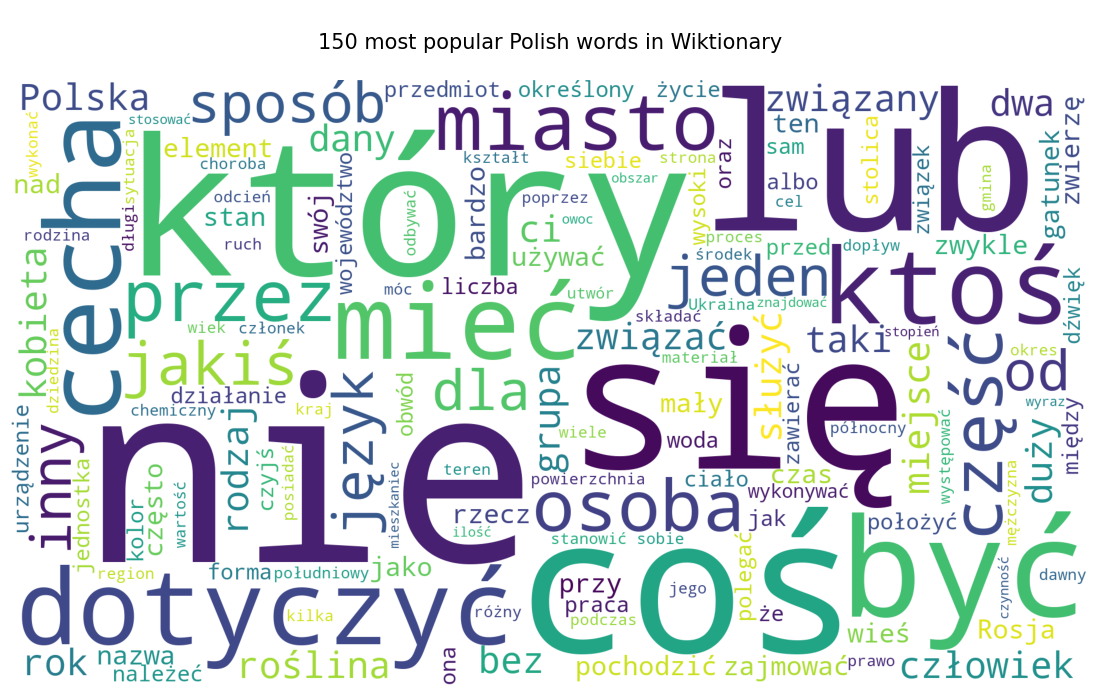

In [23]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(top_100)

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 42,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
plt.title('\n150 most popular Polish words in Wiktionary\n', fontsize = 15)
plt.axis('off')
plt.tight_layout()
plt.savefig('150_Most_popular_Polish_words.jpg')

plt.show()

<h4>b) Number of words per difinition</h4>

In [36]:
import scipy
iqr = scipy.stats.iqr(wiki_dict_all['No_words'].values)
q25 = np.quantile(wiki_dict_all['No_words'].values, 0.25)
q75 = np.quantile(wiki_dict_all['No_words'].values, 0.75)

wiki_iqr = wiki_dict_all[(wiki_dict_all['No_words'] >= q25 - 1.5 * iqr) & (wiki_dict_all['No_words'] <= q75 + 1.5 * iqr)]
wiki_iqr

Name    Sign                    Type  \
0                          Å  (1, 1)                    None   
1              Île-de-France  (1, 1)              rzeczownik   
2              Île-de-France  (1, 2)              rzeczownik   
3                          Ó  (1, 1)              rzeczownik   
4                          à  (1, 1)                przyimek   
...                      ...     ...                     ...   
141240           z wyjątkiem  (1, 1)        fraza przyimkowa   
141241           z założenia  (1, 1)      fraza przysłówkowa   
141242  z zamkniętymi oczami  (1, 1)      fraza przysłówkowa   
141243     z zapałem neofity  (1, 1)  związek frazeologiczny   
141244              z zasady  (1, 1)      fraza przysłówkowa   

                                               Definition  \
0        metrol. fiz. symbol jednostki długości angstrem    
1       geogr. hist. kraina historyczna zawierająca Pa...   
2       adm. region administracyjny Francji ,  zawiera...   
3       jęz. majuskuła dwudziestej pierwszej litery al...   
4              – używane w handlu przy określaniu ilości    
...                                                   ...   
141240                                            oprócz    
141241  ,  zgodnie z planem ,  założeniem ,  według pl...   
141242                                    ,  bez wahania    
141243       energią  i  zacięciem osoby nowo nawróconej    
141244  z własnymi przekonaniami lub powszechnie respe...   

                                              Other_words  \
0          ['symbol', 'jednostka', 'długość', 'angstrem']   
1       ['kraina', 'historyczny', 'zawierać', 'Paryż',...   
2       ['region', 'administracyjny', 'Francja', 'zawi...   
3       ['majuskuła', 'dwudziesty', 'pierwszy', 'liter...   
4       ['–', 'używać', 'w', 'handel', 'przy', 'określ...   
...                                                   ...   
141240                                                 []   
141241  ['zgodnie z', 'plan', 'założenie', 'według', '...   
141242                                    ['bez wahania']   
141243  ['energia', 'zacięcie', 'osoba', 'nowo', 'nawr...   
141244  ['z', 'własny', 'przekonanie', 'lub', 'powszec...   

                    Indexes  No_words  No_apperance  
0       ['metrol.', 'fiz.']         6             0  
1       ['geogr.', 'hist.']        14             4  
2                  ['adm.']        12             4  
3                  ['jęz.']         8             0  
4                       NaN         7             2  
...                     ...       ...           ...  
141240                  NaN         1             0  
141241                  NaN        10             0  
141242                  NaN         2             0  
141243                  NaN         6             0  
141244                  NaN         7             0  

[133779 rows x 8 columns]

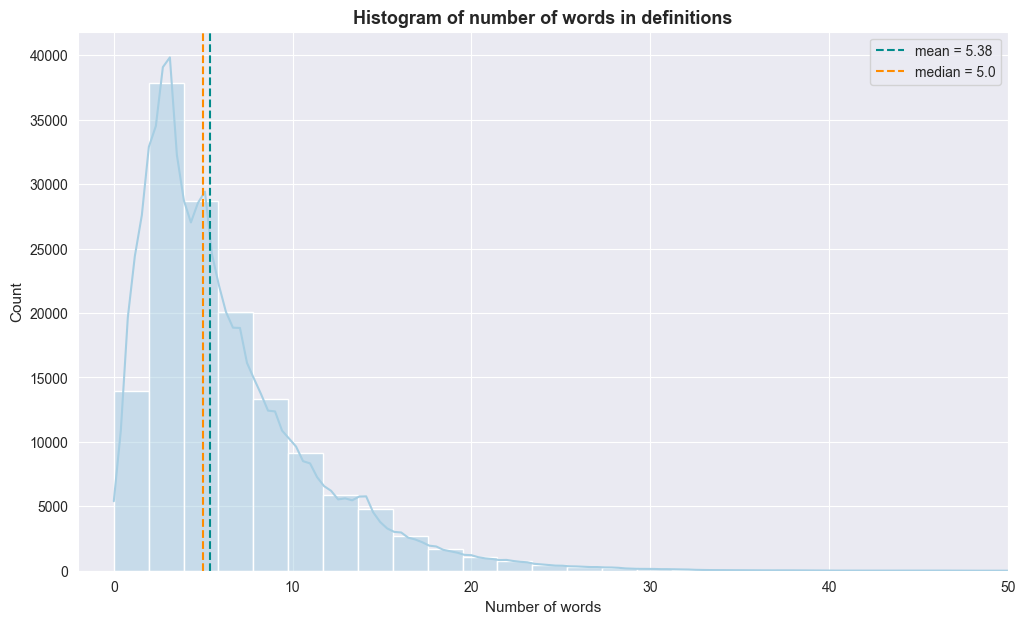

In [38]:
# KDE plots for each Payment Method
plt.figure(figsize = (12, 7))
sns.set_style('darkgrid')
sns.set_palette('Paired')
sns.histplot(data = wiki_dict_all, x = 'No_words', bins = 40, kde = True)

plt.axvline(wiki_iqr['No_words'].mean(), linestyle = '--', c = 'darkcyan', label = 'mean = {0}'.format(round(wiki_iqr['No_words'].mean(), 2)))
plt.axvline(wiki_iqr['No_words'].median(), linestyle = '--', c = 'darkorange', label = 'median = {0}'.format(round(wiki_iqr['No_words'].median(), 2)))
plt.xlabel('Number of words', fontsize = 11)
plt.ylabel('Count', fontsize = 11)
plt.xlim([-2, 50])
plt.title('Histogram of number of words in definitions', size = 13, weight = 'bold')
plt.legend()

plt.savefig('Histogram_number_of_words.jpg')
plt.show()

We have around 100 000 entries with 145 000 meanings. Above we plot the histogram with number of words per definition, but we exclude the outliers (some headwords are 45-55 words long). The median is 5 words and the mean of the headwords’ definition is 5.38 words (including pronouns or prepositions) and it is longer for proverbs, idiomatic expressions and adverb’s phrases, when it is shorter for sufixes, prefixes and  punctuation marks. 

<h4>c) Fraction of phases of speak in the language</h4>

In [24]:
def part_of_speach(dataframe):
    word_main_types = []
    
    for i in tqdm(range(dataframe.shape[0]), desc = 'Typ czesci mowy'):
        word_type = dataframe.iloc[i, 2]
        
        if 'rzeczownik' in word_type:
            word_main_types.append('rzeczownik')
        
        elif 'czasownik' in word_type:
            word_main_types.append('czasownik')
        
        elif 'przymiotnik' in word_type:
            word_main_types.append('przymiotnik')
        
        elif 'liczebnik' in word_type:
            word_main_types.append('liczebnik')
        
        elif 'zaimek' in word_type:
            if 'zaimek przysłowny' in word_type:
                word_main_types.append('zaimek przysłowny')
            else:
                word_main_types.append('zaimek (rzeczowny, przymiotny, liczebny)')
        
        # Nieodmienne części mowy  
        elif 'przysłówek' in word_type:
            word_main_types.append('przysłówek')
        
        elif 'spójnik' in word_type:
            word_main_types.append('spójnik')
        
        elif 'wykrzynik' in word_type:
            word_main_types.append('wykrzyknik')
        
        elif 'partykuła' in word_type:
            word_main_types.append('partykuła')
        
        elif 'przyimek' in word_type:
            word_main_types.append('przyimek')
            
        elif 'imiesłów' in word_type:
            word_main_types.append('imiesłów')
            
        else:
            word_main_types.append(word_type)
            
    dataframe['Main_type'] = word_main_types
    return dataframe


In [25]:
speach_parts_df = part_of_speach(wiki_dict_all)

Typ czesci mowy: 100%|██████████| 141245/141245 [00:03<00:00, 36028.70it/s]


In [26]:
speech_df = speach_parts_df.copy()
speech_df.drop_duplicates('Name', keep = 'first', inplace = True)
customer_senior_percent = speech_df['Main_type'].value_counts(normalize = True)
customer_senior_percent.head(7)

top15_percent = customer_senior_percent.head(7)
sum_of_rest = customer_senior_percent[7:].sum()
sum_of_rest

top15_percent.loc['Rest'] = sum_of_rest

In [78]:
customer_senior_percent.tail(20)

przyrostek słowotwórczy                                 0.000021
końcówka fleksyjna                                      0.000021
fraza interpunkcyjna                                    0.000021
forma słowotwórcza                                      0.000021
przysłowie polskie[1]                                   0.000010
wyraz o charakterze ekspresywnym                        0.000010
modulant[zob. uwagi]                                    0.000010
wykrzyknik parentetyczny                                0.000010
składnik kilku przysłówków złożonych miejsca i czasu    0.000010
forma ściągnięta                                        0.000010
fraza przysłówkowa stopnia i miary                      0.000010
fraza przysłówkowa przyczyny                            0.000010
fraza zaimkowa wskazująca                               0.000010
związek wyrazów w funkcji podmiotu i orzeczenia         0.000010
fraza zaimkowa rzeczowna                                0.000010
przedrostek w wyrazach zł

In [42]:
top15_percent.index

Index(['rzeczownik', 'przymiotnik', 'czasownik', 'przysłówek',
       'przysłowie polskie', 'związek frazeologiczny', 'fraza przysłówkowa',
       'Rest'],
      dtype='object')

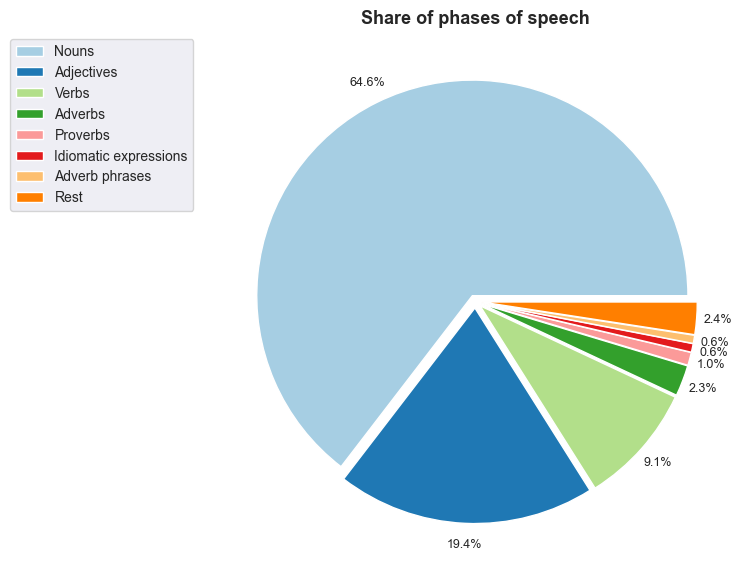

In [676]:
sns.set_palette('Paired')
plt.figure(figsize = (12, 7))

plt.pie(top15_percent, explode = [0.03 for i in range(top15_percent.shape[0])], autopct = '%1.1f%%', 
        textprops = {'fontsize': 9}, pctdistance = 1.1, labeldistance=1.2)
plt.title('Share of phases of speech', fontsize = 13, weight = 'bold')
plt.legend(labels = ['Nouns', 'Adjectives', 'Verbs', 'Adverbs', 'Proverbs',
                     'Idiomatic expressions', 'Adverb phrases', 'Rest'], bbox_to_anchor = (-0.01, 1.0), fontsize = 10)
plt.savefig('Share_of_phases_of_speech.jpg')
plt.show()

The most part of all headwords are nouns with 64% of the whole Wiktionary, adjectives which are about 19.5% of whole headwords and verbs, which fraction is equal to 9.1%. The least part, which are in this graph assigned to Rest, are expressive words, lower forms and interfixes, with one ten thousandth of words.

<h4>d) Most popular nouns, verbs, adjectives and adverbs</h4> 

<b>--> Nouns</b>

In [27]:
most_popular = speach_parts_df.copy()
#most_popular.drop_duplicates('Name', keep = 'first', inplace = True)
top_50_nouns = most_popular[most_popular['Main_type'] == 'rzeczownik'][['Name', 'No_apperance']].sort_values(by = 'No_apperance', 
                                                                                                        ascending = False)

In [28]:
top_50_nouns.drop_duplicates('Name', keep = 'first', inplace = True)
top_50_nouns = dict(top_50_nouns.head(80).values)

del top_50_nouns['dany']
del top_50_nouns['mały']
del top_50_nouns['sam']
del top_50_nouns['jak']
del top_50_nouns['bez']
del top_50_nouns['albo']

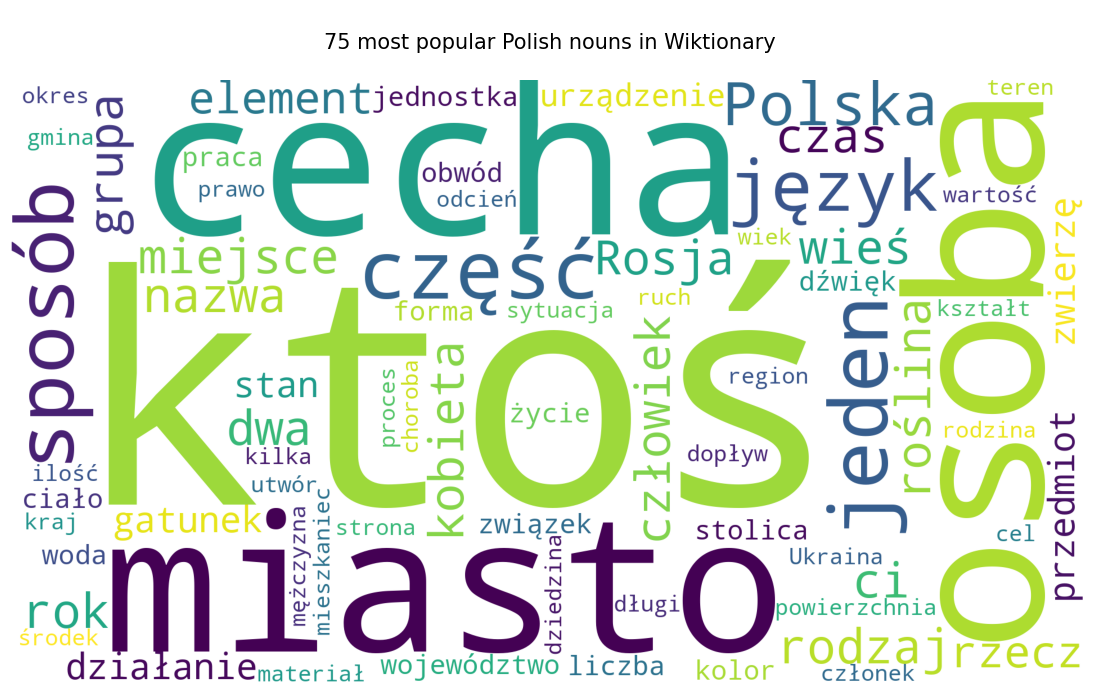

In [29]:
plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(top_50_nouns)

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 123,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.title('\n75 most popular Polish nouns in Wiktionary\n', fontsize = 15)
plt.tight_layout()
plt.savefig('Most_popular_nouns.jpg')
plt.show()

<b>--> Verbs</b>

In [30]:
most_popular = speach_parts_df.copy()
#most_popular.drop_duplicates('Name', keep = 'first', inplace = True)
top_75_verbs = most_popular[most_popular['Main_type'] == 'czasownik'][['Name', 'No_apperance']].sort_values(by = 'No_apperance', 
                                                                                                        ascending = False)

In [31]:
top_75_verbs.drop_duplicates('Name', keep = 'first', inplace = True)
top_75_verbs = dict(top_75_verbs.head(86).values)

In [88]:
top_75_verbs

{'lub': 12009,
 'być': 6310,
 'dotyczyć': 5934,
 'mieć': 2812,
 'związany': 1580,
 'związać': 1345,
 'służyć': 958,
 'dany': 937,
 'zajmować': 904,
 'używać': 870,
 'pochodzić': 862,
 'zwierzę': 737,
 'określony': 711,
 'położyć': 648,
 'polegać': 580,
 'zawierać': 557,
 'należeć': 542,
 'wykonywać': 504,
 'kraj': 478,
 'składać': 441,
 'występować': 427,
 'posiadać': 422,
 'móc': 418,
 'wykonać': 404,
 'stanowić': 394,
 'odbywać': 393,
 'znajdować': 392,
 'stosować': 386,
 'przeznaczyć': 363,
 'urodzić': 362,
 'odnosić': 358,
 'posługiwać': 354,
 'tworzyć': 348,
 'gra': 326,
 'powstać': 323,
 'postać': 322,
 'działać': 315,
 'prowadzić': 308,
 'przypominać': 283,
 'robić': 279,
 'obejmować': 269,
 'bądź': 268,
 'łączyć': 264,
 'zrobić': 258,
 'powodować': 256,
 'mówić': 256,
 'dawać': 251,
 'wyrażać': 250,
 'wykorzystywać': 249,
 'wydawać': 248,
 'broń': 239,
 'zostać': 227,
 'zamieszkiwać': 220,
 'stać': 218,
 'grać': 214,
 'określać': 209,
 'wywodzić': 202,
 'dać': 199,
 'umożliwiać

In [32]:
del top_75_verbs['lub']
del top_75_verbs['związany']
del top_75_verbs['zwierzę']
del top_75_verbs['określony']
del top_75_verbs['gra']
del top_75_verbs['bądź']
del top_75_verbs['broń']
del top_75_verbs['stały']
del top_75_verbs['wyrób']
del top_75_verbs['złożony']
del top_75_verbs['kraj']
del top_75_verbs['dany']

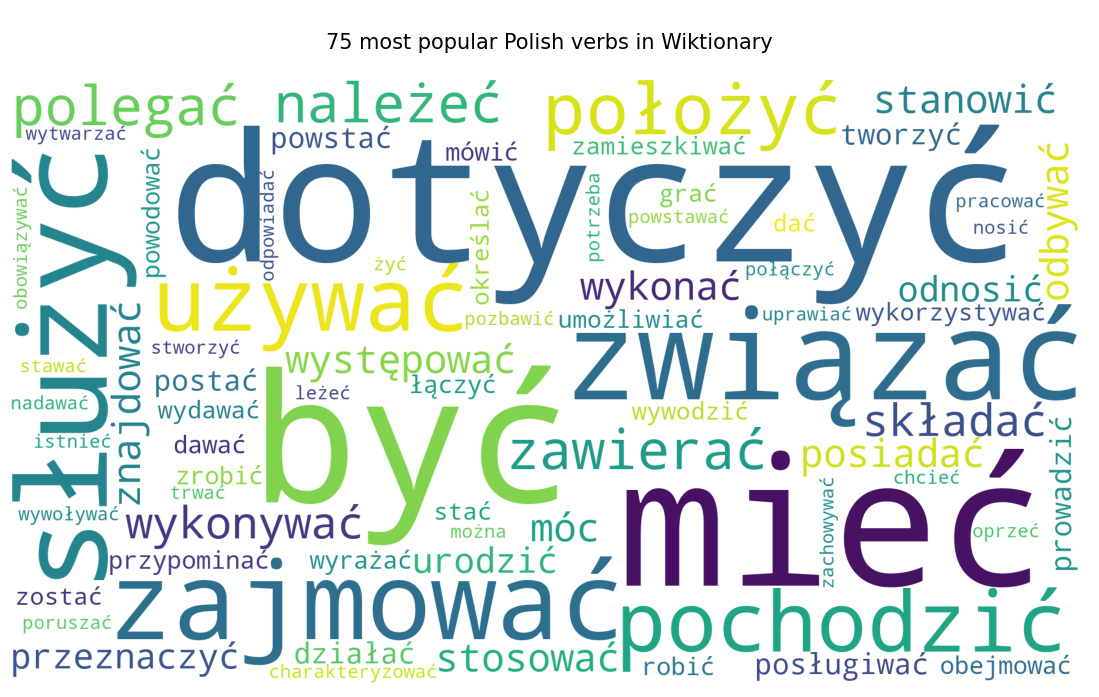

In [33]:
plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(top_75_verbs)

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 10,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.title('\n75 most popular Polish verbs in Wiktionary\n', fontsize = 15)
plt.tight_layout()
plt.savefig('Most_popular_verbs.jpg')
plt.show()

<b>--> Adjectives</b>

In [34]:
most_popular = speach_parts_df.copy()
#most_popular.drop_duplicates('Name', keep = 'first', inplace = True)
top_75_adj = most_popular[most_popular['Main_type'] == 'przymiotnik'][['Name', 'No_apperance']].sort_values(by = 'No_apperance', 
                                                                                                        ascending = False)

In [35]:
top_75_adj.drop_duplicates('Name', keep = 'first', inplace = True)
top_75_adj = dict(top_75_adj.head(75).values)

In [36]:
del top_75_adj['droga']
del top_75_adj['powierzchnia']

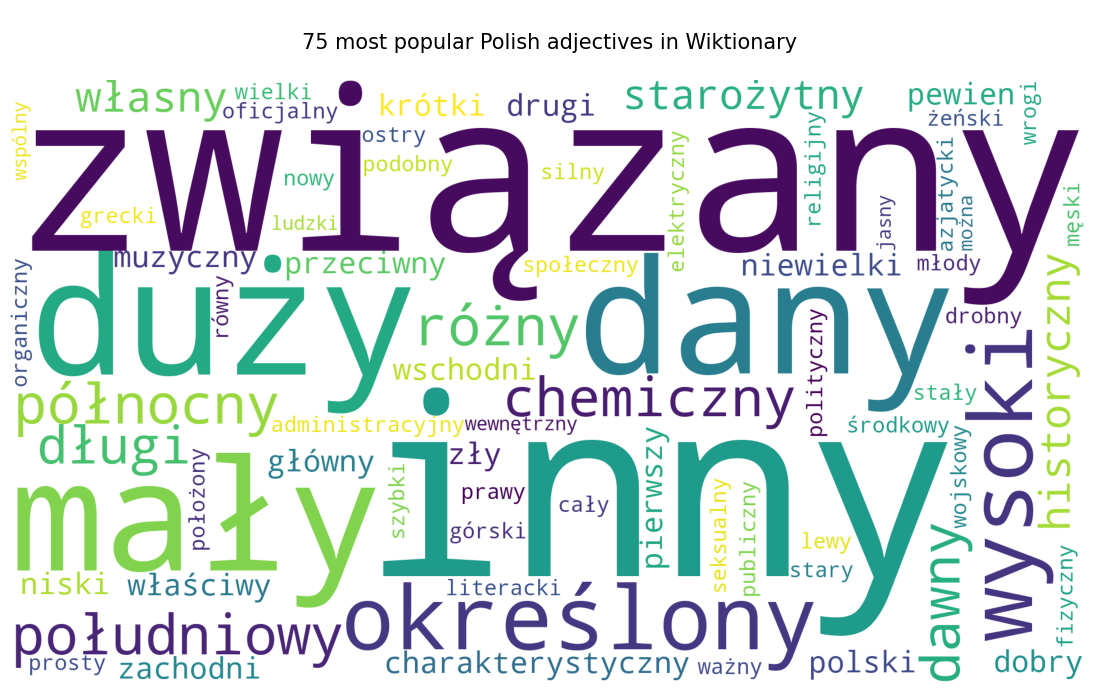

In [37]:
plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(top_75_adj)

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 42,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.title('\n75 most popular Polish adjectives in Wiktionary\n', fontsize = 15)
plt.tight_layout()
plt.savefig('Most_popular_adjectives.jpg')
plt.show()

<b>--> Adverbs</b>

In [38]:
most_popular = speach_parts_df.copy()
#most_popular.drop_duplicates('Name', keep = 'first', inplace = True)
top_75_adverbs = most_popular[most_popular['Main_type'] == 'przysłówek'][['Name', 'No_apperance']].sort_values(by = 'No_apperance', 
                                                                                                        ascending = False)

In [39]:
top_75_adverbs.drop_duplicates('Name', keep = 'first', inplace = True)
top_75_adverbs = dict(top_75_adverbs.head(75).values)

In [57]:
top_75_adverbs

{'bardzo': 838,
 'często': 803,
 'zwykle': 762,
 'oraz': 668,
 'podczas': 466,
 'wiele': 463,
 'prawo': 398,
 'wewnątrz': 302,
 'punkt': 288,
 'głównie': 286,
 'szybko': 228,
 'zazwyczaj': 218,
 'tak': 215,
 'mało': 199,
 'dobrze': 140,
 'zbyt': 135,
 'szczególnie': 127,
 'mocno': 127,
 'czasem': 121,
 'zgodnie': 118,
 'rzadko': 103,
 'łatwo': 100,
 'dawniej': 99,
 'źle': 94,
 'całkowicie': 93,
 'obecnie': 91,
 'nawzajem': 87,
 'zewnątrz': 87,
 'wzdłuż': 83,
 'blisko': 83,
 'wzajemnie': 77,
 'obok': 75,
 'długo': 75,
 'ciepło': 75,
 'wysoko': 74,
 'bezpośrednio': 74,
 'częściowo': 73,
 'razem': 71,
 'najczęściej': 71,
 'wcześnie': 70,
 'dawno': 68,
 'jednocześnie': 68,
 'gwałtownie': 64,
 'zupełnie': 64,
 'silnie': 63,
 'przesadnie': 60,
 'dokładnie': 59,
 'zawodowo': 59,
 'intensywnie': 57,
 'niezbyt': 57,
 'niekiedy': 55,
 'powszechnie': 53,
 'wolno': 52,
 'lekko': 51,
 'nieco': 51,
 'szkoda': 50,
 'następnie': 49,
 'poniżej': 49,
 'wyłącznie': 48,
 'powoli': 47,
 'zimno': 47,
 'dale

In [40]:
del top_75_adverbs['prawo']
del top_75_adverbs['punkt']

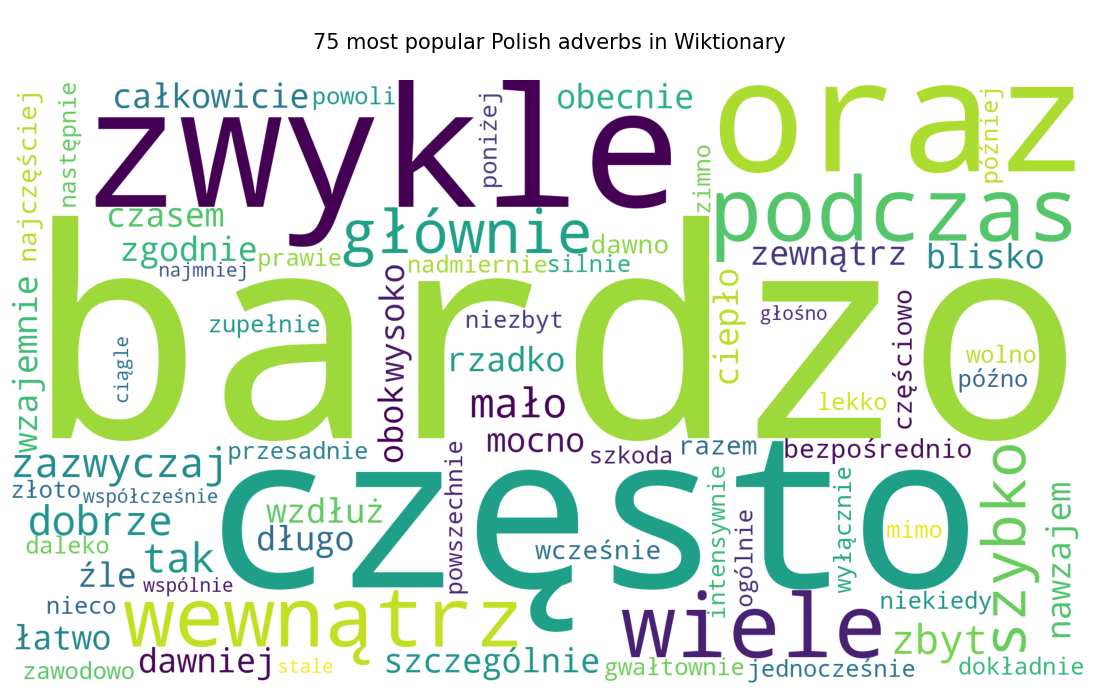

In [41]:
plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(top_75_adverbs)

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 123,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.title('\n75 most popular Polish adverbs in Wiktionary\n', fontsize = 15)
plt.tight_layout()
plt.savefig('Most_popular_adverbs.jpg')
plt.show()

We can see the nouns, verbs, adjectives and adverbs, which that occur most often in the definitions of other headwords. For noun there are feature, who, city, person, part, Poland and sound. For verbs there are to be, to come from, to occupy. On the other hand, for adjectives and adverbs we have big, small, tied, another tall and someone who, very, often, usually, inside.

<h4>e) Most words starting on a letter</h4>

In [77]:
def letter_counter(dataframe):
    count_dictionary = {}
    a = ['a', 'ą', 'b', 'c', 'ć', 'd', 'e', 'ę', 'f', 'g','h', 'i',  'j', 'k', 'l', 'ł', 
         'm', 'n', 'ń','o', 'ó', 'p', 'q', 'r', 's', 'ś', 't', 'u', 'v', 'w', 'y', 'z', 'ź', 'ż']
    
    for j in tqdm(range(dataframe.shape[0]), desc = 'Progress'):
        words_description = dataframe.iloc[j, 3]
        
        try:
            for k in range(len(words_description)):
                if (words_description[k] in count_dictionary) and (words_description[k] in a):
                    letter = words_description[k].lower()
                    freqeuncy = count_dictionary[letter] + 1
                    exist_pair = {letter : freqeuncy}
                    count_dictionary.update(exist_pair)

                else:
                    if words_description[k] in a:
                        letter = words_description[k].lower()
                        new_pair = {letter : 1}
                        count_dictionary.update(new_pair)
        except:
            pass

    df = pd.DataFrame(count_dictionary.items(), columns=['Letter', 'No_apps'])
    return df

In [78]:
letter_popular = letter_counter(wiki_dict_all)

Progress: 100%|██████████| 141245/141245 [00:09<00:00, 14825.26it/s]


In [90]:
letter_popular['Number_of_apps'] = round(letter_popular['No_apps'] / letter_popular['No_apps'].sum(), 4) * 100

In [91]:
letter_popular['Number_of_apps']

0     2.46
1     7.52
2     3.85
3     4.61
4     8.11
5     2.23
6     0.30
7     8.69
8     6.09
9     3.79
10    3.84
11    1.91
12    1.87
13    3.68
14    5.23
15    3.74
16    1.12
17    2.47
18    1.62
19    0.86
20    4.48
21    8.05
22    1.06
23    4.50
24    1.30
25    0.97
26    3.00
27    0.88
28    0.85
29    0.22
30    0.07
31    0.62
32    0.00
33    0.01
Name: Number_of_apps, dtype: float64

In [94]:
letter_popular = letter_popular.sort_values(by = 'Letter')

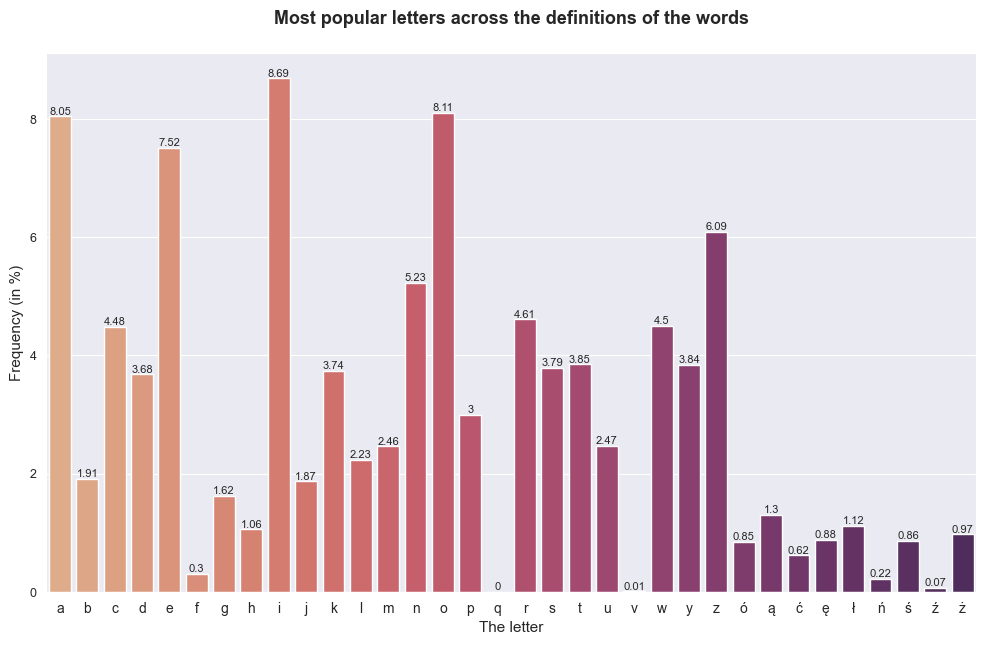

In [96]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (12, 7))

sns.barplot(data = letter_popular, x = 'Letter', y = 'Number_of_apps', palette = 'flare', ax = ax)

for container in ax.containers:
    ax.bar_label(container, fontsize = 8)

plt.xlabel('The letter', fontsize = 11)
plt.ylabel('Frequency (in %)', fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 9)
plt.title('Most popular letters across the definitions of the words\n', fontsize = 13, weight = 'bold')

plt.savefig('Popular_letters.jpg')
plt.show()

In our case the most popular Polish letter is 'i', on the second place is 'o' and on the third 'a' with properly 8.69%, 8.11% and 8.05% of frequency apperance in the definitions of the words. There all are vowels. These results are similar to the information provided by National Corpus of Polish Language, whose results of analyzing the Polish language are that the most popular letters are 'a' (8.91%),  'i' (8.21%) and 'o' (7.75%). Like in the official stats the most popular consonant is 'z' (in our case - 6.09% and in National Corpus - 5.64%).

In [353]:
def starting_letter_counter(dataframe):
    count_dictionary = {}
    
    for j in tqdm(range(dataframe.shape[0]), desc = 'Progress'):
        try:
            first_letter = str(dataframe.iloc[j, 0].lower())[0]
        except:
            first_letter = str(dataframe.iloc[j, 0].lower())[0]
        
        if first_letter in count_dictionary:
            freqeuncy = count_dictionary[first_letter] + 1
            exist_pair = {first_letter : freqeuncy}
            count_dictionary.update(exist_pair)
                
        else:
            new_pair = {first_letter : 1}
            count_dictionary.update(new_pair)

    df = pd.DataFrame(count_dictionary.items(), columns=['Letter', 'No_apperance'])
    return df


In [354]:
letter_df = wiki_dict_all.copy()
letter_df.drop_duplicates('Name', keep = 'first', inplace = True)
letter_count = starting_letter_counter(letter_df)

Progress: 100%|██████████| 95564/95564 [00:02<00:00, 34250.27it/s]


In [360]:
letter_count.drop([0, 1, 3, 4, 5, 6, 7, 9, 13, 16, 17, 18, 19, 20, 21], axis = 0)
letter_count = letter_count[letter_count['No_apperance'] > 4]
letter_count = letter_count[letter_count['No_apperance'] != 171]

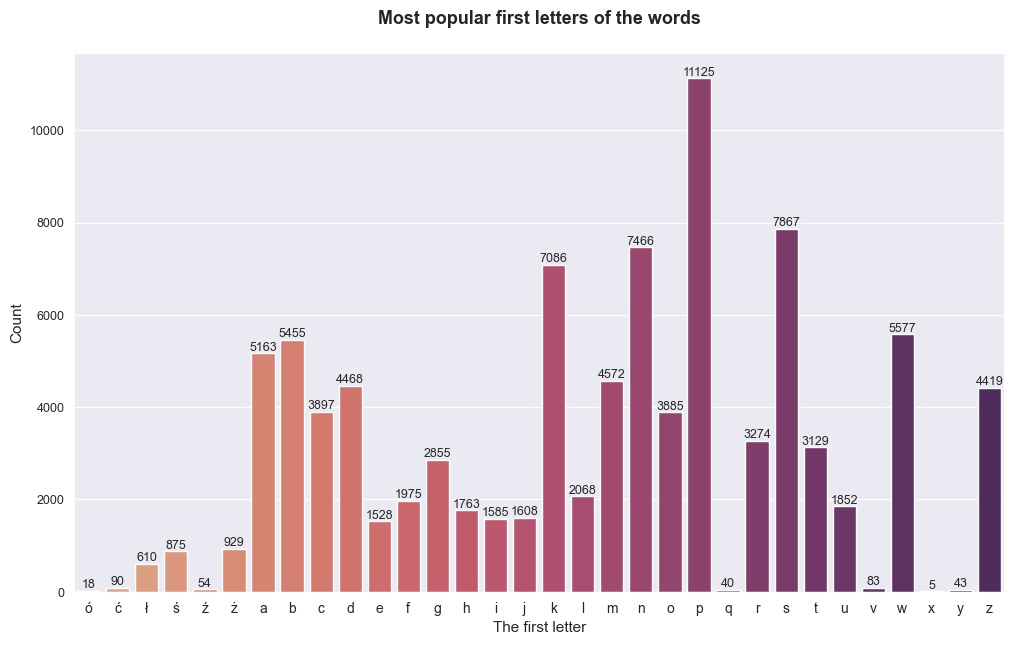

In [687]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (12, 7))

sns.barplot(data = letter_count, x = 'Letter', y = 'No_apperance', palette = 'flare', ax = ax)

for container in ax.containers:
    ax.bar_label(container, fontsize = 9)

plt.xlabel('The first letter', fontsize = 11)
plt.ylabel('Count', fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 9)
plt.title('Most popular first letters of the words\n', fontsize = 13, weight = 'bold')

plt.savefig('Popular_first_letter.jpg')
plt.show()

The most popular first letter of the words are ‘p’ with 11 125 headwords in Polish Wiktionary and this statistic coincides with what we were able to find on the internet. According to the National Corpus of Polish the largest number of words in Poland begins with the letter 'p' -, it is over 25,000 words. But we have differences on the next places, because in our case the second and the third most popular letters are ‘s’ and ‘n’, and Corpus told that there are ‘w’ and ‘o’.

<h4>f) Abbreviations</h4>

In [395]:
def abbreviation_count(dataframe):
    count_dictionary = {}
    
    for j in tqdm(range(dataframe.shape[0]), desc = 'Progress'):
        try:
            words_description = list(dataframe.iloc[j, 5].split(" "))
            for k in range(len(words_description)):

                if words_description[k].strip("[',']") in count_dictionary:
                    freqeuncy = count_dictionary[words_description[k].strip("[',']")] + 1
                    exist_pair = {words_description[k].strip("[',']") : freqeuncy}
                    count_dictionary.update(exist_pair)

                else:
                    new_pair = {words_description[k].strip("[',']") : 1}
                    count_dictionary.update(new_pair)
        except:
            pass

    df = pd.DataFrame(count_dictionary.items(), columns=['Abbreviation', 'No_apperance'])

    return df, count_dictionary


In [396]:
cuts = abbreviation_count(wiki_dict_all)

Progress: 100%|██████████| 141245/141245 [00:04<00:00, 33142.46it/s]


In [398]:
len(cuts[1])

478

In [399]:
cuts[0]

Abbreviation  No_apperance
0        metrol.            60
1           fiz.           317
2         geogr.          4439
3          hist.          1722
4           adm.          1155
..           ...           ...
473   połączeniu             1
474           a:             1
475            a             1
476       zatem.             1
477   ogólnopol.             1

[478 rows x 2 columns]

In [402]:
with open('skrot.txt') as cut_file:
    lines = cut_file.readline()
    print(lines)

abaz.



In [445]:
# Using readlines()
file1 = open('skrot.txt', 'r', encoding='utf-8')
Lines = file1.readlines()
  
count = 0
cut_dict = {}
# Strips the newline character
Lines[0].strip('\n'), Lines[5].strip('\n')
len(Lines)

1230

In [446]:
cuts_dict = {}

for i in range(0, len(Lines), 2):
    try:
        new_pair = {Lines[i].strip('\n') : Lines[i+1].strip('\n')}
        cuts_dict.update(new_pair)
    except:
        pass

cuts_dict

{'abaz.': 'język abazyński',
 'abch.': 'język abchaski',
 'abl.': 'ablatyw',
 'adm.': 'administracja (państwowa, rządowa itd.)',
 'afr.': 'język afrykanerski',
 'agrot.': 'agrotechnika, agrotechniczny',
 'akad.': 'język akadyjski',
 'akad. franc.': 'język francuski używany w kanadyjskich prowincjach atlantyckich (Nowy Brunszwik, Nowa Szkocja, Wyspa Księcia Edwarda)',
 'akust.': 'akustyka, akustyczny',
 'alb.': 'język albański',
 'alg.': 'dialekt alguerès języka katalońskiego',
 'algier. arab.': 'algierski arabski, język arabski używany w Algierii',
 'amer.': 'amerykański angielski',
 'anat.': 'anatomia, anatomiczny',
 'ang.': 'język angielski',
 'angol. port.': 'język portugalski używany w Angoli',
 'antrop.': 'antropologia, antropologiczny',
 'aor.': 'aoryst',
 'arab.': 'język arabski',
 'arab. Hiszp.': 'język arabski używany w Hiszpanii',
 'arachn.': 'arachnologia, arachnologiczny',
 'aram.': 'język aramejski',
 'archit.': 'architektura, architektoniczny',
 'archeol.': 'archeologia, 

In [447]:
cuts_dict['fiz.']

'fizyka, fizyczny'

In [448]:
def cuts_column_creator(dataframe, dictionary):
    cuts_column = []
    
    for i in tqdm(range(dataframe.shape[0])):
        abbreviation = dataframe.iloc[i, 0]
        try:
            cut = dictionary[abbreviation]
            cuts_column.append(cut)
        except:
            cuts_column.append(abbreviation)
            
    dataframe['Full_abbreviation'] = cuts_column
    return dataframe


In [449]:
skrot_df = cuts_column_creator(cuts[0], cuts_dict)

100%|██████████| 478/478 [00:00<00:00, 19972.68it/s]


In [474]:
skrot_df = skrot_df[(skrot_df['Full_abbreviation'] != 'zobacz') & (skrot_df['Full_abbreviation'] != 'biernik') 
                    & (skrot_df['Full_abbreviation'] != 'rzeczownik') & (skrot_df['Full_abbreviation'] != 'i tym podobne, i temu podobne') &
                   (skrot_df['Full_abbreviation'] != 'na przykład')]
top30_skrot = skrot_df.sort_values(by = 'No_apperance', ascending = False).head(25)

In [475]:
top30_skrot

Abbreviation  No_apperance  \
25       odczas.          6025   
2         geogr.          4439   
7            gw.          3784   
10       zdrobn.          2541   
9           pot.          2510   
3          hist.          1722   
55          daw.          1430   
71      odprzym.          1269   
4           adm.          1155   
90          med.          1147   
19          rel.           985   
23       przest.           961   
46        polit.           906   
40        przen.           873   
18        kulin.           735   
87        techn.           719   
14       książk.           691   
5           jęz.           635   
31          reg.           600   
122         muz.           580   
67         rzad.           565   
158        chem.           554   
49        wojsk.           531   
91          bot.           501   
47         żart.           494   

                                     Full_abbreviation  
25                                      odczasownikowy  
2                              geografia, geograficzny  
7                                              gwarowe  
10                             zdrobnienie, zdrobniale  
9                                  potocznie, potoczny  
3                  historia, historyczny, historycznie  
55                                      dawniej, dawny  
71                                    odprzymiotnikowy  
4              administracja (państwowa, rządowa itd.)  
90                                  medycyna, medyczny  
19   religioznawstwo, religia, religioznawczy, reli...  
23                          przestarzałe, przestarzały  
46   politologia, polityka, politologiczny, polityczny  
40                              przenośnia, przenośnie  
18                                kulinaria, kulinarny  
87                   technologia, technika, techniczny  
14                                      książkowy styl  
5                        językoznawstwo, językoznawczy  
31                             regionalizm, regionalny  
122      muzykologia, muzyka, muzykologiczny, muzyczny  
67                              rzadki, rzadko używany  
158                                  chemia, chemiczny  
49                                wojskowość, wojskowy  
91                                botanika, botaniczny  
47                                         żartobliwie

In [683]:
labels = ['Gerund', 'Geography', 'Local dialect', 'Diminutive', 'Common words',
          'History', 'Past words', 'Adjective nouns', 'Administration', 'Medicine',
          'Religion', 'Outdated words', 'Politology', 'Figuratively words', 'Culinary',
          'Technology', 'Book style', 'Linguistics', 'Regionalisms', 'Music',
          'Rarely used words', 'Chemistry', 'Military', 'Botanic', 'Humorous words']

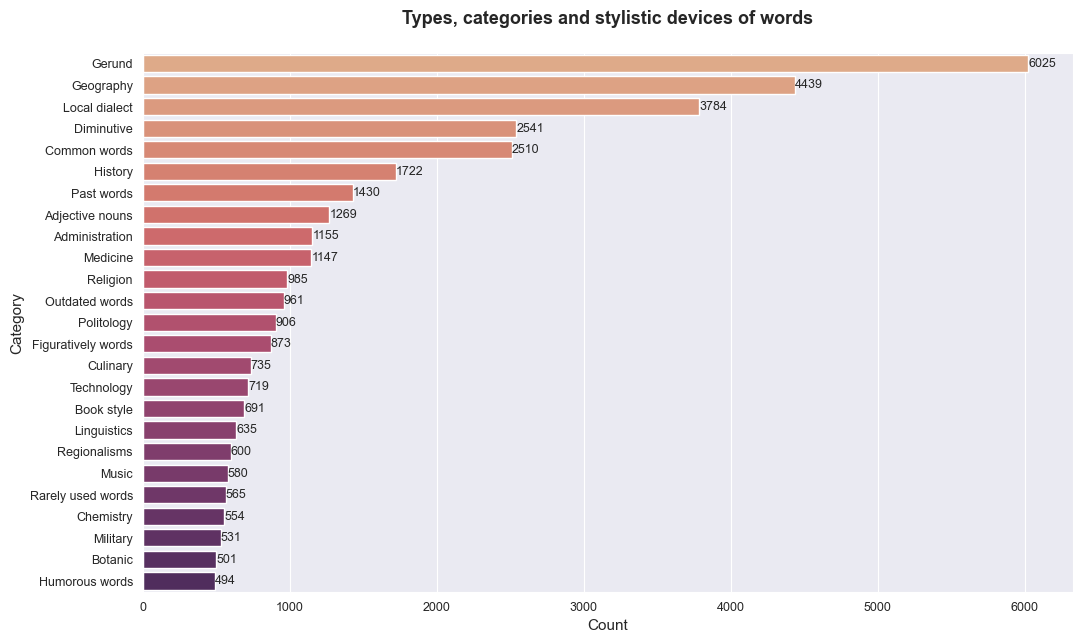

In [686]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (12, 7))

sns.barplot(data = top30_skrot, y = labels, x = 'No_apperance', palette = 'flare', ax = ax)

for container in ax.containers:
    ax.bar_label(container, fontsize = 9)

plt.xlabel('Count', fontsize = 11)
plt.ylabel('Category', fontsize = 11)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.title('Types, categories and stylistic devices of words\n', fontsize = 13, weight = 'bold')

plt.savefig('Types_categories.jpg')
plt.show()

We examined the abbreviations in the definitions that denote the origin of the words (but from other parts of speech) and the assigned domain. In general, most words are classified as gerund nouns. We also see many words from the dialect or colloquial words or diminutives. Among the fields, geography dominates due to the large number of cities and towns in the dictionary alone, but there are also history, administration and medicine, where the number of words exceeds the threshold of 1000.

<h4>g) Words from other languages</h4>

In [481]:
wiki_dict_all[wiki_dict_all['Indexes'].str.contains('jęz.') == True]

Name    Sign            Type  \
3               Ó  (1, 1)      rzeczownik   
10              å  (1, 1)          symbol   
14              ó  (1, 1)      rzeczownik   
210             Ł  (1, 1)      rzeczownik   
376             ł  (1, 1)      rzeczownik   
...           ...     ...             ...   
138760  zelandzki  (2, 1)      rzeczownik   
138841     zerowy  (1, 4)  przymiotnik[1]   
139011    zgłoska  (1, 1)      rzeczownik   
140542    zrostek  (1, 1)      rzeczownik   
140784     zwarty  (1, 2)     przymiotnik   

                                               Definition  \
3       jęz. majuskuła dwudziestej pierwszej litery al...   
10      jęz. litera używana w tekstach naukowych do za...   
14      jęz. dwudziesta pierwsza litera polskiego alfa...   
210     jęz. majuskuła szesnastej litery alfabetu ;  z...   
376     jęz. szesnasta litera polskiego alfabetu ;  zo...   
...                                                   ...   
138760  jęz. grupa gwar języka niderlandzkiego ,  używ...   
138841                   jęz. pusty ,  nie mający treści    
139011                                  jęz. zob. sylaba    
140542  jęz. element słowotwórczy dodany do leksemu , ...   
140784  jęz. o spółgłosce: taka dla której w czasie ar...   

                                              Other_words           Indexes  \
3       ['majuskuła', 'dwudziesty', 'pierwszy', 'liter...          ['jęz.']   
10      ['litera', 'używać', 'w', 'tekst', 'naukowy', ...  ['jęz.', 'tzn.']   
14      ['dwudziesty', 'pierwszy', 'litera', 'polski',...          ['jęz.']   
210       ['majuskuła', 'szesnasty', 'litera', 'alfabet']          ['jęz.']   
376          ['szesnasty', 'litera', 'polski', 'alfabet']          ['jęz.']   
...                                                   ...               ...   
138760  ['grupa', 'gwar', 'język', 'niderlandzki', 'uż...          ['jęz.']   
138841                  ['pusty', 'nie', 'mieć', 'treść']          ['jęz.']   
139011                                                 []  ['jęz.', 'zob.']   
140542  ['element', 'słowotwórczy', 'dodać', 'do', 'le...          ['jęz.']   
140784  ['taka', 'dla', 'który', 'w czasie', 'artykula...          ['jęz.']   

        No_words  No_apperance  Length    Main_type  
3              8             0       1   rzeczownik  
10            27             0       1       symbol  
14             8             0       1   rzeczownik  
210            7             1       1   rzeczownik  
376            7             1       1   rzeczownik  
...          ...           ...     ...          ...  
138760        16             0       9   rzeczownik  
138841         6            14       6  przymiotnik  
139011         3             8       7   rzeczownik  
140542        13             1       7   rzeczownik  
140784        16            30       6  przymiotnik  

[635 rows x 10 columns]

<b>--> jeżyk staropolski</b>

In [531]:
staropolski_language = wiki_dict_all.copy()
staropolski_language.drop_duplicates('Name', keep = 'first', inplace = True)

staropolski_language = staropolski_language[(staropolski_language['Indexes'].str.contains('st.pol.', regex=False) == True)]
staropolski_language

Name    Sign         Type                     Definition  \
267         Łucyja  (1, 1)   rzeczownik     st.pol. przest. gw. Łucja    
372            łża  (1, 1)   rzeczownik              st.pol. kłamstwo    
374          łżywy  (1, 1)  przymiotnik  st.pol. kłamliwy ,  fałszywy    
466          łacny  (1, 1)  przymiotnik                 st.pol. łatwy    
468         łaczny  (1, 1)  przymiotnik               st.pol. łaknący    
...            ...     ...          ...                            ...   
140258     zołwica  (1, 1)   rzeczownik                st.pol. synowa    
140267       zobać  (1, 1)    czasownik               st.pol. dziobać    
140741      zwajca  (1, 1)   rzeczownik            st.pol. awanturnik    
140912  zwiestować  (1, 1)    czasownik            st.pol. zwiastować    
141081     zwyszyć  (1, 1)    czasownik                st.pol. zyskać    

                     Other_words                        Indexes  No_words  \
267                    ['Łucja']  ['st.pol.', 'przest.', 'gw.']         4   
372                 ['kłamstwo']                    ['st.pol.']         2   
374     ['kłamliwy', 'fałszywy']                    ['st.pol.']         4   
466                    ['łatwy']                    ['st.pol.']         2   
468                  ['łaknący']                    ['st.pol.']         2   
...                          ...                            ...       ...   
140258                ['synowa']                    ['st.pol.']         2   
140267               ['dziobać']                    ['st.pol.']         2   
140741            ['awanturnik']                    ['st.pol.']         2   
140912            ['zwiastować']                    ['st.pol.']         2   
141081                ['zyskać']                    ['st.pol.']         2   

        No_apperance  Length    Main_type  
267                0       6   rzeczownik  
372                0       3   rzeczownik  
374                0       5  przymiotnik  
466                2       5  przymiotnik  
468                0       6  przymiotnik  
...              ...     ...          ...  
140258             0       7   rzeczownik  
140267             0       5    czasownik  
140741             0       6   rzeczownik  
140912             0      10    czasownik  
141081             0       7    czasownik  

[406 rows x 10 columns]

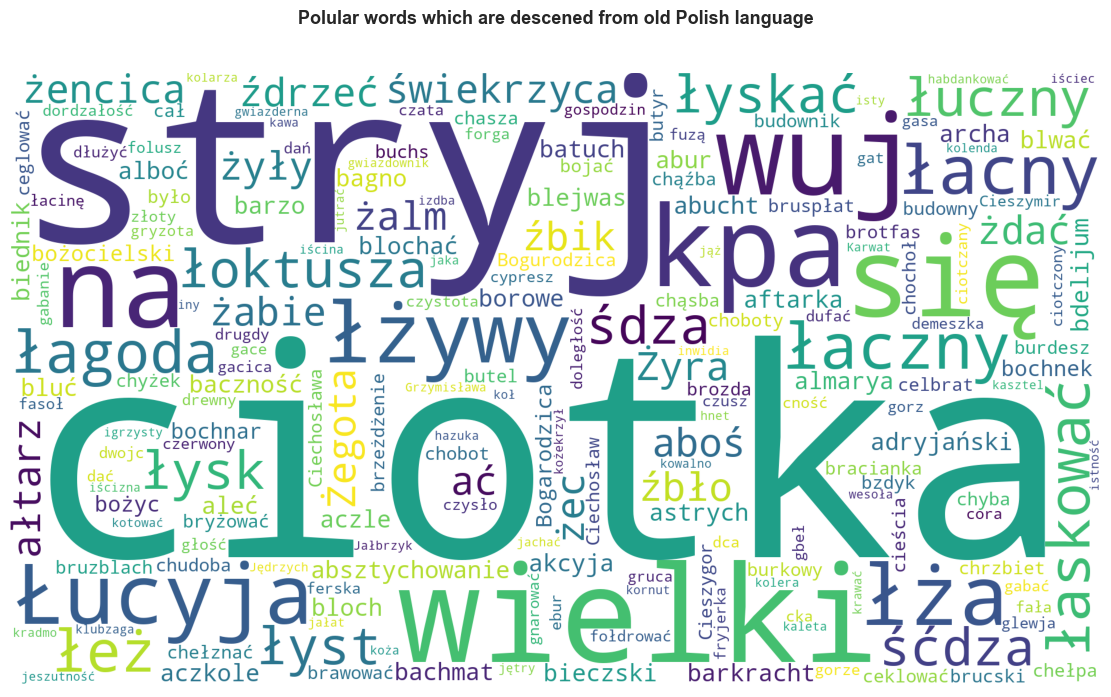

In [688]:
plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(staropolski_language['Name'])

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 123,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.title('Polular words which are descened from old Polish language\n\n', fontsize = 13, weight = 'bold')
plt.tight_layout()
plt.savefig('Old_polish_language.jpg')
plt.show()

<b>--> język średniopolski</b>

In [69]:
sredniopolski_language = wiki_dict_all.copy()
sredniopolski_language.drop_duplicates('Name', keep = 'first', inplace = True)

sredniopolski_language = sredniopolski_language[(sredniopolski_language['Indexes'].str.contains('śr.pol.', regex=False) == True)]
sredniopolski_language.shape

(28, 9)

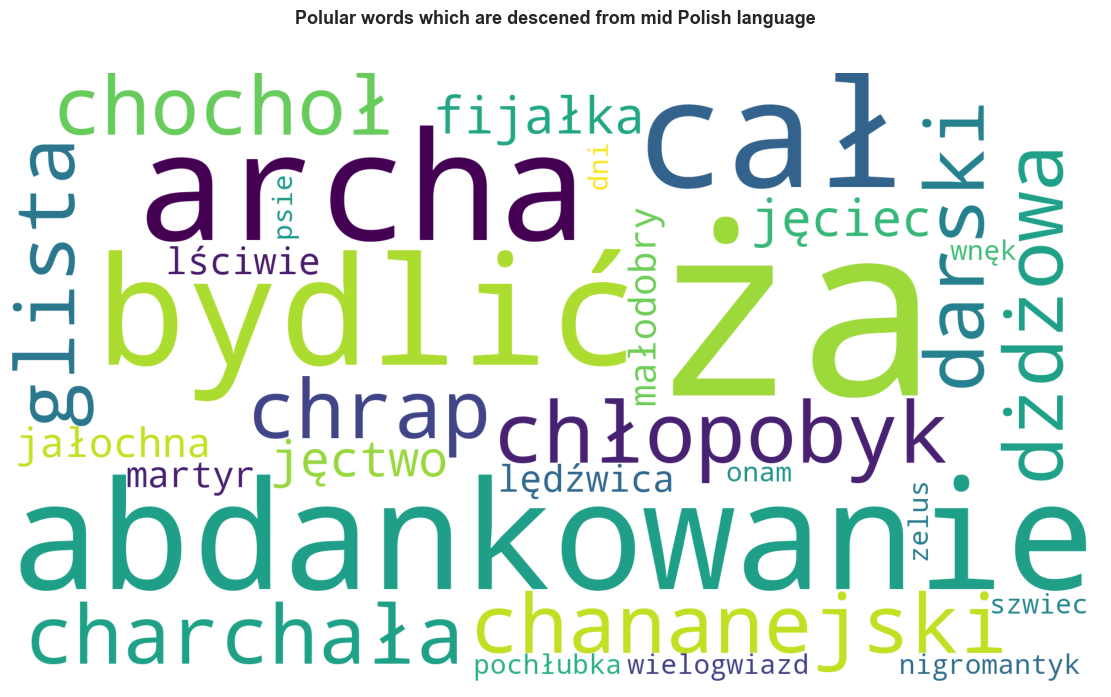

In [689]:
plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(sredniopolski_language['Name'])

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 123,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
#plt.title('Middle polish words', fontsize = 12, weight = 'bold')
plt.axis('off')
plt.title('Polular words which are descened from mid Polish language\n\n', fontsize = 13, weight = 'bold')
plt.tight_layout()
plt.savefig('Mid_polish_language.jpg')
plt.show()

<b>--> gwara</b>

In [42]:
gwara_language = wiki_dict_all.copy()
gwara_language.drop_duplicates('Name', keep = 'first', inplace = True)

gwara_language = gwara_language[(gwara_language['Indexes'].str.contains('gw.', regex=False) == True)]
gwara_language

Name    Sign                                 Type  \
15                ófnol  (1, 1)                           rzeczownik   
16                   ón  (1, 1)                               zaimek   
17              ónaczyć  (1, 1)  czasownik nieprzechodni niedokonany   
18                ónaki  (1, 1)                          przymiotnik   
61                 ćkać  (1, 1)     czasownik przechodni niedokonany   
...                 ...     ...                                  ...   
141113           zynder  (1, 1)                           rzeczownik   
141115            zynft  (1, 1)                           rzeczownik   
141116          zynklod  (1, 1)                           rzeczownik   
141117          zyntyca  (1, 1)                           rzeczownik   
141160  z inkszej biksy  (1, 1)                 fraza przymiotnikowa   

                                               Definition  \
15          gw. (Śląsk Cieszyński) rzem. gwóźdź kowalski    
16                             gw. (Śląsk Cieszyński) on    
17      gw. (Śląsk Cieszyński) pot. robić  ( o jakiejk...   
18               gw. (Śląsk Cieszyński) stosunkowo dobry    
61         pogard. gw. (Śląsk Cieszyński) jeść łapczywie    
...                                                   ...   
141113                                gw. (Poznań) łobuz    
141115  kulin. spoż. gw. (Śląsk Cieszyński i Górny Ślą...   
141116              gw. (Górny Śląsk) bud. pion murarski    
141117                                   gw. zob. żętyca    
141160                  gw. (Górny Śląsk) z innej beczki    

                                      Other_words                     Indexes  \
15                         ['gwóźdź', 'kowalski']            ['gw.', 'rzem.']   
16                                         ['on']                     ['gw.']   
17      ['robić', 'o', 'jakikolwiek', 'czynność']             ['gw.', 'pot.']   
18                        ['stosunkowo', 'dobry']                     ['gw.']   
61                          ['jeść', 'łapczywie']          ['pogard.', 'gw.']   
...                                           ...                         ...   
141113                                  ['łobuz']                     ['gw.']   
141115                              ['musztarda']  ['kulin.', 'spoż.', 'gw.']   
141116                       ['pion', 'murarski']             ['gw.', 'bud.']   
141117                                         []             ['gw.', 'zob.']   
141160                         ['z innej beczki']                     ['gw.']   

        No_words  No_apperance                                 Main_type  
15             5             0                                rzeczownik  
16             3             0  zaimek (rzeczowny, przymiotny, liczebny)  
17             9             0                                 czasownik  
18             4             0                               przymiotnik  
61             5             0                                 czasownik  
...          ...           ...                                       ...  
141113         3             0                                rzeczownik  
141115         5             0                                rzeczownik  
141116         5             0                                rzeczownik  
141117         3             0                                rzeczownik  
141160         3             0                               przymiotnik  

[3463 rows x 9 columns]

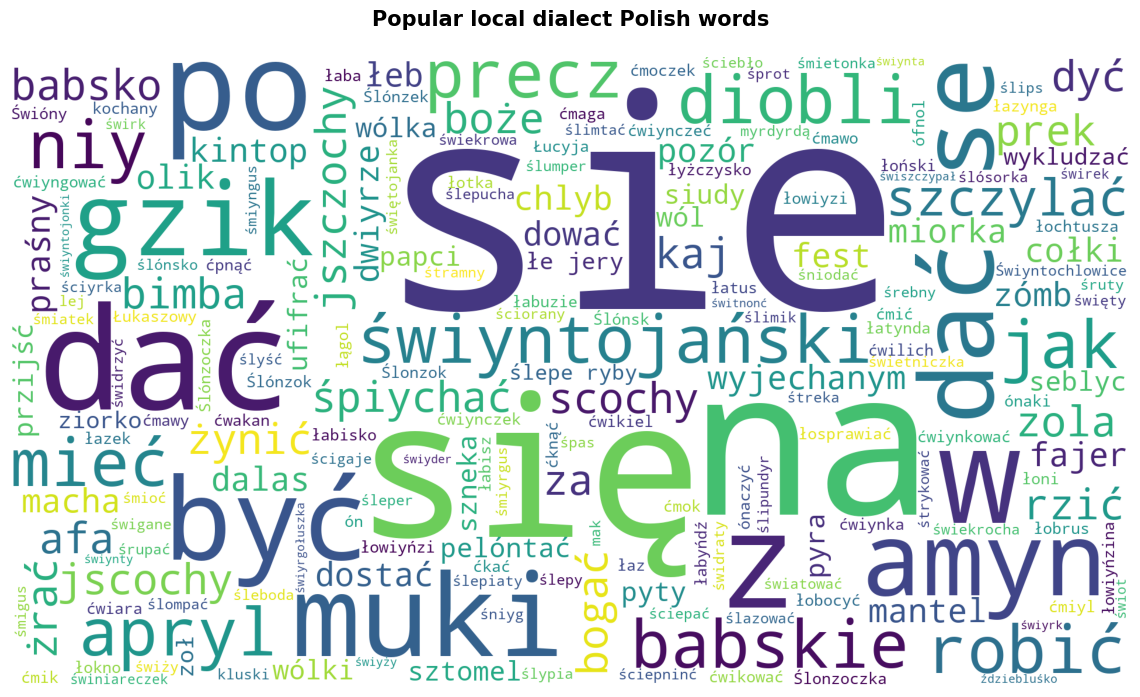

In [43]:
plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(gwara_language['Name'])

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 123,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
#plt.title('Middle polish words', fontsize = 12, weight = 'bold')
plt.axis('off')
plt.title('Popular local dialect Polish words\n', fontsize = 15, weight = 'bold')
plt.tight_layout()
plt.savefig('Gwara_polish_language.jpg')
plt.show()

There are 406 headwords descended from Old Polish language (which was used between the 10th and the 16th centuries), 28 headwords descended from Middle Polish (is the period in the history of the Polish language between the 16th and 18th centuries and it evolved from Old Polish, and gave rise to Modern Polish), 635 regionalisms and 3463 dialect words.

In [20]:
def regionalizm_counter(dataframe):
    count_dictionary = {}
    
    for j in tqdm(range(dataframe.shape[0]), desc = 'Progress'):
        try:
            part_word = gwara_language.iloc[j, 3]
            start, end = part_word.rfind('('), part_word.rfind(')')
            region = part_word[start+1:end]
            
            if region in count_dictionary:
                freqeuncy = count_dictionary[region] + 1
                exist_pair = {region : freqeuncy}
                count_dictionary.update(exist_pair)

            else:
                new_pair = {region : 1}
                count_dictionary.update(new_pair)
        except:
            pass

    df = pd.DataFrame(count_dictionary.items(), columns=['Region', 'No_apperance'])

    return df, count_dictionary


In [21]:
regions_df = regionalizm_counter(gwara_language)

Progress: 100%|██████████| 3463/3463 [00:00<00:00, 28696.95it/s]


In [22]:
regions = regions_df[0][(regions_df[0]['Region'] != 'Śląsk Cieszyński i Górny Śląsk') & (regions_df[0]['Region'] != 'Śląsk Cieszyński i Zaolzie') &
                       (regions_df[0]['Region'] != 'gw. bocian , bocian biały')]
regions = regions.sort_values('No_apperance', ascending = False).head(11)

In [23]:
regions = regions.drop(109)

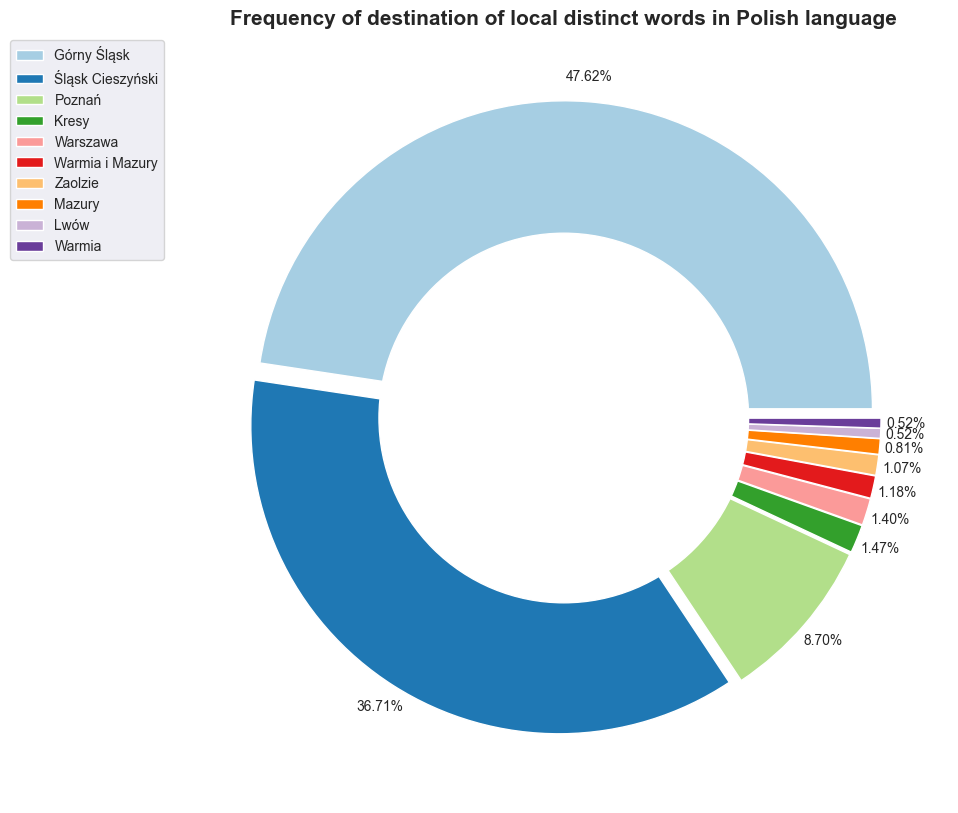

In [72]:
sns.set_palette('Paired')
plt.figure(figsize = (10, 10))
my_circle = plt.Circle((0,0), 0.6, color = 'white')

# Custom wedges in donut chart
plt.pie(regions['No_apperance'], autopct = '%1.2f%%',
        pctdistance = 1.08, explode = [0.03 for i in regions['No_apperance']])

p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Frequency of destination of local distinct words in Polish language', fontsize = 15, weight = 'bold')

plt.legend(labels = [i for i in regions['Region']], bbox_to_anchor = (-0.01, 1.0), fontsize = 10)
plt.savefig('Gwara_destination.jpg')
plt.show()

Most of dialect words are descended from Silesia – there is above 80% of whole dialect words which are descended from there, when most of the regionalisms come from Wielkopolska and Kresy – that was the eastern part of Poland between World Wars with Wilno, Brześć or Lwów.

<b>--> Region words</b>

In [44]:
reg_language = wiki_dict_all.copy()
reg_language.drop_duplicates('Name', keep = 'first', inplace = True)

reg_language = reg_language[(reg_language['Indexes'].str.contains('reg.', regex=False) == True)]
reg_language

Name    Sign                 Type  \
112           ćpnięcie  (1, 1)           rzeczownik   
587           łamignat  (1, 1)           rzeczownik   
758                łaz  (1, 1)           rzeczownik   
846             łożgol  (1, 1)           rzeczownik   
879            łodziak  (1, 1)           rzeczownik   
...                ...     ...                  ...   
139437       zieziulka  (1, 1)           rzeczownik   
139471   zimne zapusty  (1, 1)  fraza rzeczownikowa   
140025  znachodzić się  (1, 1)            czasownik   
140314           zolog  (1, 1)           rzeczownik   
140418          zozula  (1, 1)           rzeczownik   

                                               Definition  \
112                                  reg. pozn. rzucenie    
587     reg. rzad. mężczyzna silnie zbudowany ,  siłac...   
758                 gw. reg. karczowisko lub wypalenisko    
846                          reg. pozn. wysoki mężczyzna    
879                         reg. łódz. mieszkaniec Łodzi    
...                                                   ...   
139437                             reg. białost. kukułka    
139471  reg. właściwe zapusty ,  w odróżnieniu od prze...   
140025                            lub reg. znajdować się    
140314     reg. pozn. zoo ,  zoolog ,  ogród zoologiczny    
140418                                reg. wsch. kukułka    

                                              Other_words            Indexes  \
112                                          ['rzucenie']     ['reg. pozn.']   
587     ['mężczyzna', 'silnie', 'zbudować', 'siłacz', ...  ['reg.', 'rzad.']   
758                 ['karczowisko', 'lub', 'wypalenisko']    ['gw.', 'reg.']   
846                               ['wysoki', 'mężczyzna']     ['reg. pozn.']   
879                               ['mieszkaniec', 'Łódź']     ['reg. łódz.']   
...                                                   ...                ...   
139437                                        ['kukułka']  ['reg. białost.']   
139471  ['właściwy', 'zapusty', 'w', 'odróżnienie', 'o...           ['reg.']   
140025                                  ['znajdować się']           ['reg.']   
140314             ['zoo', 'zoolog', 'ogród zoologiczny']     ['reg. pozn.']   
140418                                        ['kukułka']  ['reg.', 'wsch.']   

        No_words  No_apperance   Main_type  
112            2             0  rzeczownik  
587           11             0  rzeczownik  
758            5             0  rzeczownik  
846            3             0  rzeczownik  
879            3             1  rzeczownik  
...          ...           ...         ...  
139437         2             0  rzeczownik  
139471         8             0  rzeczownik  
140025         3             0   czasownik  
140314         6             0  rzeczownik  
140418         3             1  rzeczownik  

[504 rows x 9 columns]

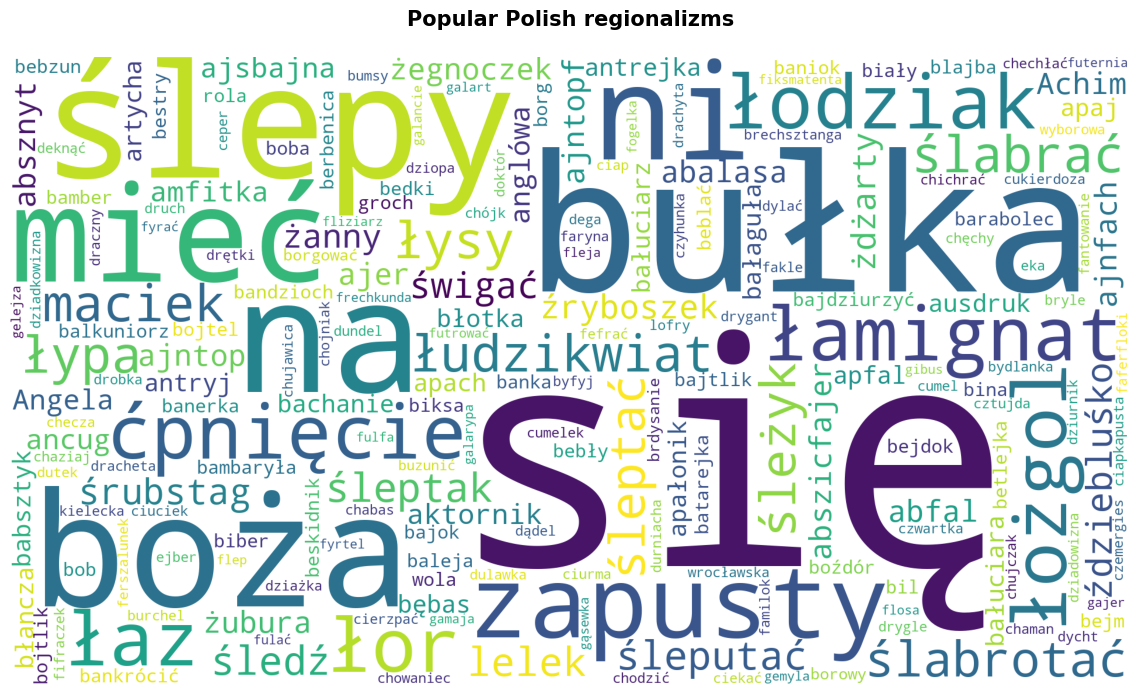

In [45]:
plt.figure(figsize = (12, 7))
separator = ' '
wordcloud_text = separator.join(reg_language['Name'])

wordcloud = WordCloud(background_color = 'white', width = 1920, height = 1080, random_state = 123,
                      contour_width = 1.5, contour_color = 'steelblue').generate(wordcloud_text)

plt.imshow(wordcloud)
#plt.title('Regional words in Polish language', fontsize = 12, weight = 'bold')
plt.axis('off')
plt.title('Popular Polish regionalizms\n', fontsize = 15, weight = 'bold')
plt.tight_layout()
plt.savefig('Region_polish_language.jpg')
plt.show()

In [81]:
wiki_dict_all[wiki_dict_all['Name'] == 'praśny']

Name    Sign         Type  \
95344  praśny  (1, 1)  przymiotnik   

                                            Definition  \
95344  gw. przaśny ,  surowy ,  świeży ,  niegotowany    

                                          Other_words  Indexes  No_words  \
95344  ['przaśny', 'surowy', 'świeży', 'niegotowany']  ['gw.']         8   

       No_apperance    Main_type  
95344             0  przymiotnik

Among the Wiktionary there are a few very odd headwords as:

* ćpnięcie – it means hitting in dialect from Cieszyn Silesia,
* łożgol – it means tall man in dialect from Wielkopolska,
* ófnol (gwóźdź Kowalski) – it means smith’s nail from Cieszyn Silesia,
* praśny – it means fresh or not cooked, it is dialect word in many Polish villages,
* or zozula (kukułka) – cuckoo, it came from Kresy.

<h3>Simple stats of the Polish language</h3>

<h4>a) Word with the longest definition</h4>

In [620]:
wiki_dict_all[wiki_dict_all['No_words'] == wiki_dict_all['No_words'].max()]

Name    Sign        Type  \
39309  gomukhasana  (1, 1)  rzeczownik   

                                              Definition  \
39309  z asan ;  pozycja siedząca ,  w której nogi są...   

                                             Other_words Indexes  No_words  \
39309  ['z', 'asana', 'pozycja', 'siedzieć', 'w', 'kt...     NaN        78   

       No_apperance  Length   Main_type  
39309             0      11  rzeczownik

In [621]:
wiki_dict_all.iloc[39309, 3]

'z asan ;  pozycja siedząca ,  w której nogi są skrzyżowane w taki sposób ,  że lewe kolano znajduje się na szczycie prawego  ( lub odwrotnie ),  a lewa stopa i łydka wzdłuż prawego biodra ,  natomiast prawa stopa i łydka znajdują się na zewnątrz lewego biodra ;  plecy są wyprostowane ;  dłonie są splecione na plecach przy jednoczesnym unoszeniu prawego łokcia w kierunku sufitu i wyciąganiu lewego w kierunku podłogi  ( lub odwrotnie ,  przy odwrotnym splocie nóg ) '

The longest definition of the headwords is for gomukhasana – this is the name for one of the yoga positions, which is called often cow’s face, when you sitted on the ground with crossed thighs, hands clasped behind the back and head directed towards the ceiling.

<h4>b) Words / Phrase with the longest length</h4>

In [625]:
wiki_dict_all.sort_values(by = 'Length', ascending = False).head(10)

Name    Sign  \
134268  w dzień świętej Agaty, jeśli słonko przez okie...  (1, 1)   
70616   na świętego Walentego bywa zwykle mróz niczego...  (1, 1)   
23973   czasem luty się zlituje, że człek niby wiosnę ...  (1, 1)   
38062   gdy pająk w lipcu przychodzi, to za sobą deszc...  (1, 1)   
46160   jak drozdy śpiewają na wierzchołkach drzew, wi...  (1, 1)   

                      Type                                         Definition  \
134268  przysłowie polskie  początku lutego w okolicach wspomnienia św. Ag...   
70616   przysłowie polskie  pogoda w dzień świętego Walentego  ( 14 lutego...   
23973   przysłowie polskie  w lutym bywa bardzo mroźna lub przeciwnie  –  ...   
38062   przysłowie polskie  szukające schronienia w domostwach w lipcu zap...   
46160   przysłowie polskie  drozdów ,  siedzących w górnej części koron dr...   

                                              Other_words  Indexes  No_words  \
134268  ['początek', 'luty', 'w', 'okolica', 'wspomnie...  ['św.']        19   
70616   ['pogoda', 'w', 'dzień', 'święty', 'Walenty', ...      NaN        12   
23973   ['w', 'luty', 'bywać', 'bardzo', 'mroźny', 'lu...      NaN        11   
38062   ['szukać', 'schronienie', 'w', 'domostwo', 'w'...      NaN         9   
46160   ['drozd', 'siedzieć', 'w', 'górny', 'część', '...      NaN        12   

        No_apperance  Length           Main_type  
134268             0      96  przysłowie polskie  
70616              0      89  przysłowie polskie  
23973              0      89  przysłowie polskie  
38062              0      86  przysłowie polskie  
46160              0      81  przysłowie polskie

In [626]:
# Przysłowie polskie
wiki_dict_all.iloc[70616, 0]

'w dzień świętej Agaty, jeśli słonko przez okienko zajrzy do chaty, to wiosenka na świat podgląda zza zimowej kraty'

In [68]:
a = 'pozycja siedząca, w której nogi są skrzyżowane w taki sposób , że lewe kolano znajduje się na szczycie prawego (lub odwrotnie), a lewa stopa i łydka wzdłuż prawego biodra, natomiast prawa stopa i łydka znajdują się na zewnątrz lewego biodra; plecy są wyprostowane; dłonie są splecione na plecach przy jednoczesnym unoszeniu prawego łokcia w kierunku sufitu i wyciąganiu lewego w kierunku podłogi  (lub odwrotnie, przy odwrotnym splocie nóg'
len(a.strip(', '))

439

In [62]:
# Przysłowie polskie
wiki_dict_all.iloc[23973, 0]

'czasem luty się zlituje, że człek niby wiosnę czuje; ale czasem tak się zżyma, że człek prawie nie wytrzyma'

In [63]:
# Przysłowie polskie
wiki_dict_all.iloc[70616, 0]

'na świętego Walentego bywa zwykle mróz niczego, lecz jak Walek się rozdeszcze, pewne mrozy wrócą jeszcze'

In [64]:
len('W dzień świętej Agaty, jeśli słonko przez okienko zajrzy do chaty, to wiosenka na świat podgląda zza zimowej kraty')

114

In [627]:
wiki_dict_all[~(wiki_dict_all['Main_type'] == 'przysłowie polskie')].sort_values(by = 'Length', ascending = False).head(5)

Name    Sign  \
65316   Międzynarodowy Ruch Czerwonego Krzyża i Czerwo...  (1, 1)   
50980   kiedy gospodyni pierze i chleb piecze, to się ...  (1, 3)   
50979   kiedy gospodyni pierze i chleb piecze, to się ...  (1, 2)   
139676  Zjednoczone Królestwo Wielkiej Brytanii i Irla...  (1, 1)   
128212  widzieć źdźbło w oku bliźniego, a belki we wła...  (1, 1)   

                          Type  \
65316      fraza rzeczownikowa   
50980   przysłowie polskie [1]   
50979   przysłowie polskie [1]   
139676     fraza rzeczownikowa   
128212  związek frazeologiczny   

                                               Definition  \
65316   organizacja humanitarna ;  zob. też Międzynaro...   
50980   i najbardziej odpowiedzialne zadania powodują ...   
50979   kobiety łatwo się denerwują podczas prania i p...   
139676  ofic. nazwa państwa leżącego w Europie Zachodn...   
128212  źdźbło w oku bliźniego widzisz, a belki w swoi...   

                                              Other_words    Indexes  \
65316                      ['organizacja', 'humanitarny']        NaN   
50980   ['i', 'bardzo', 'odpowiedzialny', 'zadanie', '...        NaN   
50979   ['kobieta', 'łatwo', 'denerwować się', 'podcza...        NaN   
139676  ['nazwa', 'państwo', 'leżeć', 'w', 'Europa Zac...  ['ofic.']   
128212                                                 []        NaN   

        No_words  No_apperance  Length               Main_type  
65316          4             0      56              rzeczownik  
50980          7             0      55  przysłowie polskie [1]  
50979          7             0      55  przysłowie polskie [1]  
139676        18             0      54              rzeczownik  
128212         1             0      52  związek frazeologiczny

In [628]:
# Rzeczwonik
wiki_dict_all.iloc[65316, 0]

'Międzynarodowy Ruch Czerwonego Krzyża i Czerwonego Półksiężyca'

The three longest headwords in the dictionary are proverbs. We selected here only top 3, but in this metric the proverbs are placed between 1 and 6 positions. The first non proverb located in this statistic is International Red Cross and Red Crescent Movement (in Polish „Międzynarodowy Ruch Czerwonego Krzyża i Czerwonego Półksiężyca”) and United Kingdom of Great Britain and Ireland (in Polish Zjednoczone Królestwo Wielkiej Brytanii i Irlandii Północnej).

<h4>c) Word with the most number of different definitions</h4>

In [636]:
max_sign = 0
current_i = 0
for i in range(wiki_dict_all.shape[0]):
    a = int(tuple(wiki_dict_all.iloc[i, 1])[1])
    if a > max_sign:
        max_sign = a
        current_i = i

In [638]:
current_i

118386

In [79]:
wiki_dict_all[wiki_dict_all['Name'] == 'tłuc']

Name    Sign                                               Type  \
118366  tłuc  (1, 1)       czasownik przechodni niedokonany (dk. potłuc   
118367  tłuc  (1, 2)       czasownik przechodni niedokonany (dk. potłuc   
118368  tłuc  (1, 3)       czasownik przechodni niedokonany (dk. potłuc   
118369  tłuc  (2, 1)       czasownik przechodni niedokonany (dk. utłuc)   
118370  tłuc  (3, 1)      czasownik przechodni niedokonany (dk. zatłuc)   
118371  tłuc  (3, 2)      czasownik przechodni niedokonany (dk. zatłuc)   
118372  tłuc  (4, 1)      czasownik przechodni niedokonany (dk. wytłuc)   
118373  tłuc  (4, 2)      czasownik przechodni niedokonany (dk. wytłuc)   
118374  tłuc  (5, 1)      czasownik przechodni niedokonany (dk. natłuc)   
118375  tłuc  (5, 2)      czasownik przechodni niedokonany (dk. natłuc)   
118376  tłuc  (5, 3)      czasownik przechodni niedokonany (dk. natłuc)   
118377  tłuc  (6, 1)      czasownik przechodni niedokonany (dk. dotłuc)   
118378  tłuc  (6, 2)      czasownik przechodni niedokonany (dk. dotłuc)   
118379  tłuc  (7, 1)  czasownik zwrotny niedokonany tłuc się (dk. po...   
118380  tłuc  (7, 2)  czasownik zwrotny niedokonany tłuc się (dk. po...   
118381  tłuc  (7, 3)  czasownik zwrotny niedokonany tłuc się (dk. po...   
118382  tłuc  (8, 1)  czasownik zwrotny niedokonany tłuc się (dk. na...   
118383  tłuc  (8, 2)  czasownik zwrotny niedokonany tłuc się (dk. na...   
118384  tłuc  (8, 3)  czasownik zwrotny niedokonany tłuc się (dk. na...   
118385  tłuc  (8, 4)  czasownik zwrotny niedokonany tłuc się (dk. na...   
118386  tłuc  (9, 1)  czasownik zwrotny niedokonany tłuc się (dk. do...   

                                               Definition  \
118366  uderzeniami powstawanie kawałków czegoś ;  usz...   
118367  samemu mocno o coś ,  doprowadzając do miejsco...   
118368                                     mocno uderzać    
118369          uderzeniami formę lub konsystencję czego    
118370           ,  powodując powstanie głośnego odgłosu    
118371                                   bez opamiętania    
118372                           zabijać w dużej liczbie    
118373  grać na czymś intensywnie ,  długo ,  głośno a...   
118374                      miotać intensywnie pociskami    
118375             wykonywać seryjnie ,  bez staranności    
118376                             powtarzać co z uporem    
118377                             ,  rozbijać dodatkowo    
118378                              ,  rozbijać do końca    
118379                            stłuczeniu ,  rozbiciu    
118380          samemu o coś ,  wywołując wyraźny odgłos    
118381                          mocno bić jeden drugiego    
118382  powodować hałas poprzez intensywne czynności l...   
118383       podróżować długo w mało wygodnych warunkach    
118384         przemieszczać się bez celu ,  włóczyć się    
118385      o uczuciach, myślach: ciągle przypominać się    
118386               docierać do celu uciążliwej podróży    

                                              Other_words Indexes  No_words  \
118366  ['uderzenie', 'powstawanie', 'kawałek', 'co', ...     NaN         9   
118367  ['sam', 'mocno', 'o', 'coś', 'doprowadzać', 'd...     NaN         9   
118368                               ['mocno', 'uderzać']     NaN         2   
118369  ['uderzenie', 'forma', 'lub', 'konsystencja', ...     NaN         5   
118370     ['powodować', 'powstanie', 'głośny', 'odgłos']     NaN         5   
118371                             ['bez', 'opamiętanie']     NaN         2   
118372                 ['zabijać', 'w', 'duży', 'liczba']     NaN         4   
118373  ['grać', 'na', 'co', 'intensywnie', 'długo', '...     NaN        10   
118374                ['miotać', 'intensywnie', 'pocisk']     NaN         3   
118375     ['wykonywać', 'seryjnie', 'bez', 'staranność']     NaN         5   
118376                   ['powtarzać', 'co', 'z', 'upór']     NaN         4   
118377                          ['rozbijać', 'dodatkowo']     NaN 

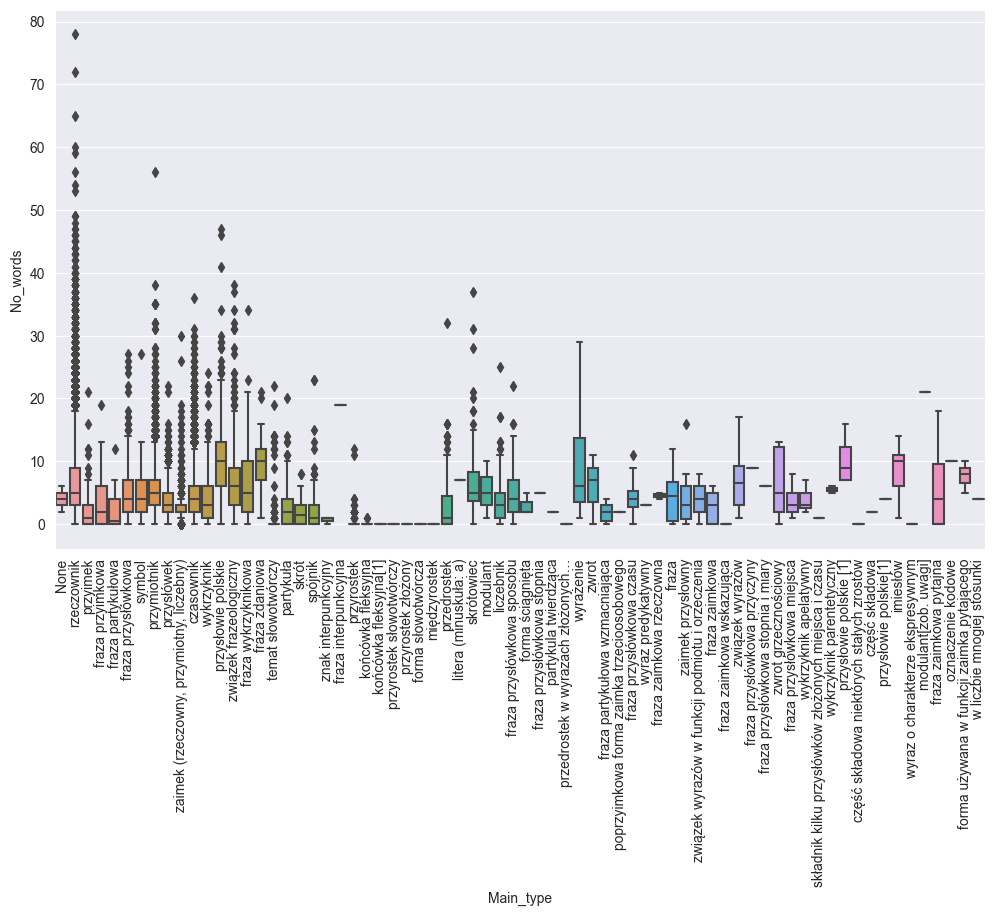

In [644]:
plt.figure(figsize = (12, 7))
sns.boxplot(data = wiki_dict_all, y = 'No_words', x = 'Main_type')
plt.xticks(rotation = 90)
plt.show()

<h4>d) Words with no type</h4>

In [647]:
wiki_dict_all[wiki_dict_all['Type'] == 'None']

Name    Sign  Type  \
0             Å  (1, 1)  None   
13684  bdelijum  (1, 1)  None   

                                             Definition  \
0      metrol. fiz. symbol jednostki długości angstrem    
13684                                  st.pol. bdelium    

                                          Other_words              Indexes  \
0      ['symbol', 'jednostka', 'długość', 'angstrem']  ['metrol.', 'fiz.']   
13684                                     ['bdelium']          ['st.pol.']   

       No_words  No_apperance  Length Main_type  
0             6             0       1      None  
13684         2             0       8      None

<h4>e) Mean of the length of the definitions</h4>

In [649]:
# With outliers
wiki_dict_all['Length'].mean(), wiki_dict_all['Length'].std()

(9.361811037558851, 4.36736769074038)

In [656]:
wiki_dict_all.groupby('Main_type')['Length'].mean().sort_values(ascending = False).head(30)

Main_type
przysłowie polskie [1]                44.000000
przysłowie polskie                    33.793965
przysłowie polskie[1]                 20.000000
fraza przysłówkowa przyczyny          18.000000
fraza przysłówkowa stopnia i miary    17.000000
fraza zdaniowa                        16.454545
związek frazeologiczny                14.021307
zwrot                                 13.000000
fraza                                 12.600000
fraza partykułowa wzmacniająca        11.909091
związek wyrazów                       11.333333
fraza wykrzyknikowa                   11.333333
wyrażenie                             11.250000
fraza przysłówkowa czasu              11.071429
imiesłów                              10.600000
przymiotnik                           10.503271
fraza przysłówkowa                    10.174324
przysłówek                             9.316599
fraza przysłówkowa sposobu             9.203008
fraza zaimkowa                         9.125000
fraza przysłówkowa stopnia    

In [485]:
skrot_df[skrot_df['Full_abbreviation'].str.contains('język ')]

Abbreviation  No_apperance    Full_abbreviation
45       st.pol.           440    język staropolski
151      śr.pol.            31  język średniopolski
206          gr.           108    język starogrecki
229         jap.             2       język japoński
319        fryz.             3      język fryzyjski
336         ang.             6      język angielski
356         poł.             4       język połabski
365         ros.             1       język rosyjski
370        arab.             1        język arabski
379         łac.             1       język łaciński
443       franc.             2      język francuski
446         pol.             2         język polski
447         tur.             1        język turecki

There are a few headwords from other languages mainly are descended from English, Polabian (West Slavic language) and French, but there are also words from Japanese, German, Turkish, Russian and Latin, but it is worth to mention that other languages words make up less than 40 words. Only Old Greek has more than 100 headwords, but this is due to many headwords that you may associate with mythology or ancient Greek history like Zeus or Agora.

In [198]:
wiki_dict_all[wiki_dict_all['Type'].str.contains('imiesłów') == True]

Name    Sign  \
73782         niepisany  (1, 1)   
73783         niepisany  (1, 2)   
75548       niewierzący  (1, 1)   
75549       niewierzący  (1, 2)   
75751   niewykształcony  (2, 1)   
90090          położony  (1, 1)   
90091          położony  (2, 1)   
90092          położony  (2, 2)   
123666   ufortyfikowany  (1, 1)   
124208           umarła  (2, 1)   
124210           umarły  (2, 1)   
125109     uspokajający  (1, 1)   
125119       uspokojony  (1, 1)   
125120       uspokojony  (1, 2)   
134957        zabłocony  (1, 1)   
135053           zabity  (1, 1)   
135054           zabity  (1, 2)   
135055           zabity  (1, 3)   
136572      zaopatrzony  (1, 1)   
139763         zmęczony  (1, 1)   
139764         zmęczony  (1, 2)   
140559       zrujnowany  (1, 1)   
140560       zrujnowany  (1, 2)   
140561       zrujnowany  (1, 3)   

                                                     Type  \
73782                                            imiesłów   
73783                                            imiesłów   
75548                      imiesłów przymiotnikowy czynny   
75549                      imiesłów przymiotnikowy czynny   
75751                                            imiesłów   
90090   imiesłów przymiotnikowy bierny w użyciu przymi...   
90091                      imiesłów przymiotnikowy bierny   
90092                      imiesłów przymiotnikowy bierny   
123666                     imiesłów przymiotnikowy bierny   
124208            imiesłów przymiotnikowy przeszły czynny   
124210            imiesłów przymiotnikowy przeszły czynny   
125109                     imiesłów przymiotnikowy czynny   
125119                     imiesłów przymiotnikowy bierny   
125120                     imiesłów przymiotnikowy bierny   
134957                                           imiesłów   
135053                     imiesłów przymiotnikowy bierny   
135054                     imiesłów przymiotnikowy bierny   
135055                     imiesłów przymiotnikowy bierny   
136572                                           imiesłów   
139763                            imiesłów przymiotnikowy   
139764                            imiesłów przymiotnikowy   
140559                     imiesłów przymiotnikowy bierny   
140560                     imiesłów przymiotnikowy bierny   
140561                     imiesłów przymiotnikowy bierny   

                                               Definition  \
73782   ,  który nie jest gwarantowany na piśmie ;  ni...   
73783   taki ,  który nie jest ustanowiony przez prawo...   
75548   ,  który nie dowierza ,  nie wierzy w coś ,  w...   
75549   w kontekście wiary, wyznania: który nie wyznaj...   
75751                                        wykształcić    
90090                      ,  usytuowany w danym miejscu    
90091                                            położyć    
90092                      ,  usytuowany w danym miejscu    
123666                                do zadań obronnych    
124208                                       zob. umrzeć    
124210                                            umrzeć    
125109                                 ,  który uspokaja    
125119    ,  który pozbył się niepokoju ,  zdenerwowania    
125120                niezakłócony ,  nieruchomy i cichy    
134957            zabłocić ;  wymazany ,  pokryty błotem    
135053                         życia przez kogoś lub coś    
135054   z utrudnioną możliwością dojścia  /  dojechania    
135055                           przez przybicie gwoździ    
136572  ,  który otrzymał zaopatrzenie ,  wyposażenie ...   
139763  zmęczenie ,  taki ,  który jest osłabiony fizy...   
139764  taki ,  który ma czegoś dość ,  jest czymś znu...   
140559                          ,  doprowadzony do ruiny    
140560             doprowadzony do katastrofy finansowej    
140561   zniszczony na zdrowiu fizycznym lub psychicznym    

                                              Other_words   Indexes  No_words  \
73782   ['